# Modelos para pronóstico de cuenta corriente (de series de tiempo y de ciencia de datos)

Debido a que los indicadores que componen la cuenta corriente se encuentran en constante revisión, las cuales pueden ser considerables, es necesario guardar las diferentes versiones con las que se corren los modelos para pronosticarla.

### Paso 1. Descargar la versión más reciente de la cuenta corriente de Banco de México

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import os
import requests



token_1='82908162e488cf6a1e53620862cd2d9fa1181ba5a78882ffeb5d29320a19a145'

def descargar_banxico(serie,fecha_inicio,fecha_fin,token=token_1,es_oportuno=False):
    #Donde:
    # serie: el identificador o identificadores que tiene Banxico para cada serie de tiempo en su sistema de información
    #       las series se pueden consultar en la siguiente liga: https://www.banxico.org.mx/SieAPIRest/service/v1/doc/catalogoSeries
    # fecha_inicio: fecha aaaa-mm-dd en la que se quiere iniciar la consulta
    # fecha_fin: fecha aaaa-mm-dd en la que se quiere concluir la consulta
    # token: el token generado por la API de Banxico para acceder

    if es_oportuno==True:
        url='https://www.banxico.org.mx/SieAPIRest/service/v1/series/'+serie+'/datos/oportuno?token='+token
    else:
        url='https://www.banxico.org.mx/SieAPIRest/service/v1/series/'+serie+'/datos/'+fecha_inicio+'/'+fecha_fin+'?token='+token
    headers = {'Token':token}
    response = requests.get(url,headers=headers)
    status=response.status_code
    raw_data = response.json()
    T=len(serie.split(","))
    info={'fecha':pd.DataFrame(raw_data['bmx']['series'][0]['datos'])['fecha']}

    for i in range(T):
        titulo=raw_data['bmx']['series'][i]['titulo']

        data=raw_data['bmx']['series'][i]['datos']

        df=pd.DataFrame(data)
        df['dato'] = df['dato'].str.replace(',', '', regex=True).str.extract('(\d+\.\d+)')[0].astype(float)
        df['dato'] = df['dato'].apply(lambda x:float(x))
        info[titulo]=df['dato']
    info=pd.DataFrame(info)
    info.set_index('fecha',inplace=True)

    return info

In [2]:
fecha_inicio='2002-01-01'
fecha_fin='2023-09-01'

corr=descargar_banxico('SE44352',fecha_inicio,fecha_fin)
corr_credito=descargar_banxico('SE44353,SE44354,SE44357,SE44363,SE44369',fecha_inicio,fecha_fin)
corr_debito=descargar_banxico('SE44372,SE44373,SE44376,SE44382,SE44390',fecha_inicio,fecha_fin)
cap=descargar_banxico('SE44393,SE44394,SE44395',fecha_inicio,fecha_fin)

In [3]:
#para guardar las versiones de cuenta corriente
#df1=pd.DataFrame(pd.concat([corr,corr_credito,corr_debito,cap],axis=1))
#df1.to_csv('/Users/1thaliaespana1/Documents/Semestre II/ambientes/sandbox_Python/estancia_investigacion/modelacion_economica/versiones_balanza_pagos/balanza_pagos_230913.csv', index=True, header=True)

In [4]:
#función que acorta los títulos específicos de balanza de pagos

def limpiar_titulo(c_corr_credito):
    for k,v in c_corr_credito.items():
        nueva=k.split("(a partir de 2002)")[1]
        c_corr_credito[nueva]=c_corr_credito.pop(k)
    return c_corr_credito
corr_credito=limpiar_titulo(corr_credito)
corr_debito=limpiar_titulo(corr_debito)
corr=limpiar_titulo(corr)
cap=limpiar_titulo(cap)



In [5]:

#Cambiar nombres de columnas
corr.rename(columns={'Cuenta corriente (I - II)':'corr'},inplace=True)
corr_credito.rename(columns={'Cuenta corriente (I - II) I. Crédito (A + B + C + D) D. Ingreso secundario':'corr_cred_ingsec',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) C. Ingreso primario':'corr_cred_ingprim',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) B. Servicios 2/':'corr_cred_serv',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) A. Bienes':'corr_cred_bien',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D)':'corr_cred',},inplace=True)
cap.rename(columns={'Cuenta de capital (I - II) II. Débito':'cap_deb',
'Cuenta de capital (I - II) I.Crédito':'cap_cred',
'Cuenta de capital (I - II)':'cap',},inplace=True)
corr_debito.rename(columns={'Cuenta corriente (I - II) II. Débito (A + B + C + D) C. Ingreso primario':'corr_deb_ingprim',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) A. Bienes':'corr_deb_bien',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) B. Servicios 2/':'corr_deb_serv',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) D. Ingreso secundario':'corr_deb_ingsec',
'Cuenta corriente (I - II) II. Débito (A + B + C + D)':'corr_deb_deb'},inplace=True)


## Análisis exploratorio de datos

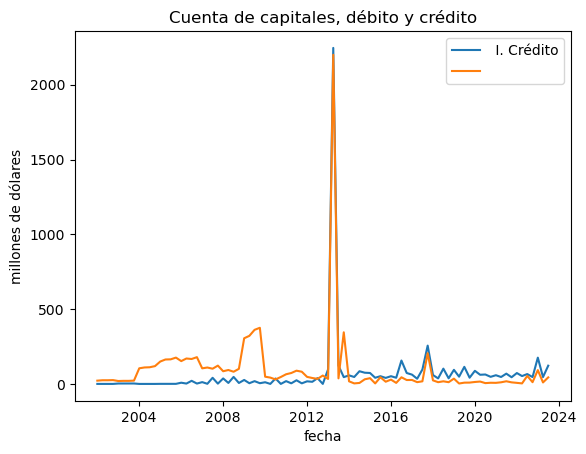

In [6]:
titulo3=[i.split('(I - II)', 1)[1] for i in cap.keys()]

x0=pd.to_datetime(list(cap.index),format="%d/%m/%Y")
y30=cap.iloc[:,1]
y31=cap.iloc[:,2]
plt.plot(x0,y30,x0,y31)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta de capitales, débito y crédito')

plt.savefig('CA_debitocredito.pdf', format="pdf", bbox_inches="tight")
plt.legend([titulo3[1],titulo3[2]])

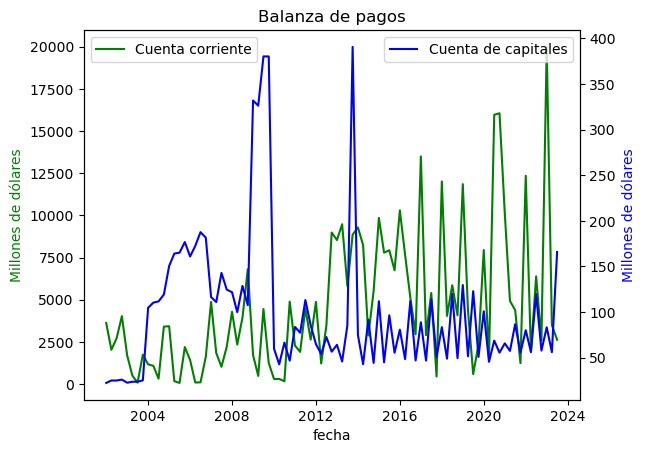

In [7]:
x0=pd.to_datetime(list(corr.index),format="%d/%m/%Y")
y00=corr.iloc[:,0]
y01=cap.iloc[:,0]

fig, ax0 = plt.subplots()

ax1 = ax0.twinx()
ax0.plot(x0, y00, 'g-')
ax1.plot(x0, y01, 'b-')

ax0.set_xlabel('fecha')
ax0.set_ylabel('Millones de dólares', color='g')
ax1.set_ylabel('Millones de dólares', color='b')

plt.title('Balanza de pagos')
ax0.legend(['Cuenta corriente'])
ax1.legend(['Cuenta de capitales'])

plt.savefig('Balanza_pagos.pdf', format="pdf", bbox_inches="tight")
plt.show()

### Cuenta corriente. Crédito

Se observa que la cuenta de crédito de cuenta corriente más grande proviene de la cuenta de bienes, la cual comprenden exportaciones de mercancías y asciende a más de 175 mil millones de pesos. Por su parte, la segunda cuenta más grande (aunque considerablemente más chica que la cuenta de bienes) es la cuenta de ingresos secundarios, los cuales son casi su totalidad ingresos por remesas y ascienden a poco menos de 23 mil millones de pesos.

Por su parte, la cuenta de servicios primarios de crédito comprende utilidades, dividendos, intereses y remuneración de empleados, y ascendió a poco menos de 23 mil millones de pesos. Por otro lado, las de servicios suman transporte, viajes, servicios empresariales, propiedad intelectual entre los más importantes.

No obstante, en saldos netos (débito - crédito) la cuenta corriente de bienes, servicios e ingresos primarios se encuentra en saldos positivos, mientras que sólo la cuenta de ingresos secundarios se encuentra en saldos negativos. Por otro lado, se observa un poco de estacionalidad en las cuentas de ingresos primarios e ingresos secundarios.

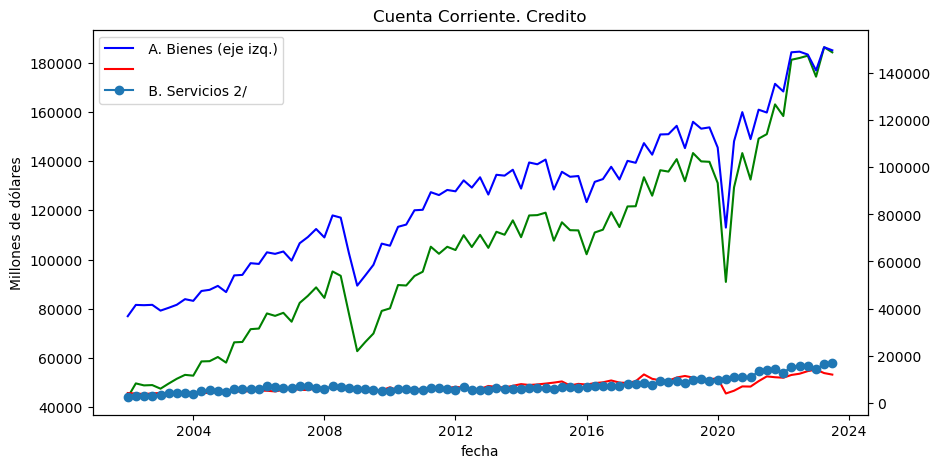

In [8]:
titulo1=[i.split('(A + B + C + D)', 1)[1] for i in corr_credito.keys()]

x1=pd.to_datetime(list(corr_credito.index),format="%d/%m/%Y")
y10=corr_credito.iloc[:,0]
y11=corr_credito.iloc[:,1]
y12=corr_credito.iloc[:,2]
y13=corr_credito.iloc[:,3]
y14=corr_credito.iloc[:,4]

fig, ax0 = plt.subplots(figsize=(10, 5))

ax1 = ax0.twinx()
ax0.plot(x1, y11, 'g-')
ax1.plot(x1, y10, 'b-')
ax1.plot(x1, y12, 'r-')
ax1.plot(x1, y13, 'o-')

ax0.set_xlabel('fecha')
ax0.set_ylabel('Millones de dólares')
plt.title('Cuenta Corriente. Credito')
plt.legend([titulo1[0]+' (eje izq.)',titulo1[1],titulo1[2],titulo1[3]],loc='upper left')

plt.savefig('CC_credito.pdf', format="pdf", bbox_inches="tight")
plt.show()

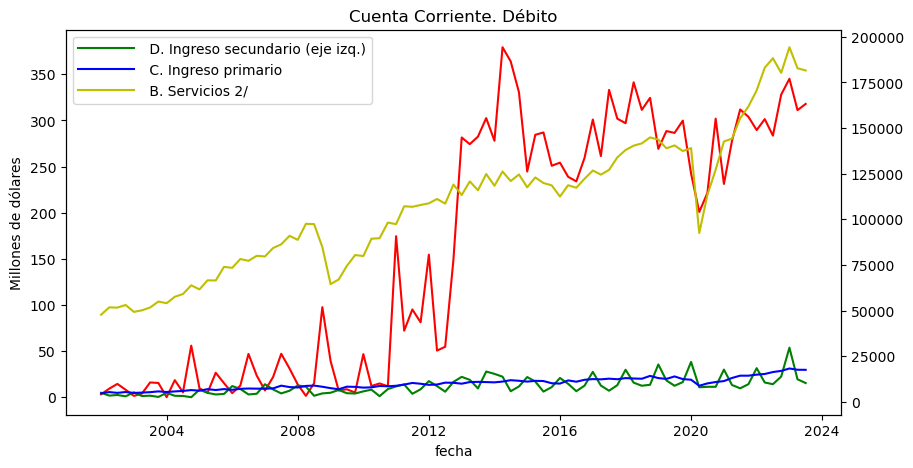

In [9]:

titulo2=[i.split('(A + B + C + D)', 1)[1] for i in corr_debito.keys()]

x2=pd.to_datetime(list(corr_debito.index),format="%d/%m/%Y")
y20=corr_debito.iloc[:,0]
y21=corr_debito.iloc[:,1]
y22=corr_debito.iloc[:,2]
y23=corr_debito.iloc[:,3]
y24=corr_debito.iloc[:,4]


fig, ax0 = plt.subplots(figsize=(10, 5))

ax1 = ax0.twinx()
ax0.plot(x1, y22,'r')
ax1.plot(x1, y20,'g')
ax1.plot(x1, y23,'b')
ax1.plot(x1, y24,'y')

ax0.set_xlabel('fecha')
ax0.set_ylabel('Millones de dólares')
plt.title('Cuenta Corriente. Débito')
plt.legend([titulo2[2]+' (eje izq.)',titulo2[0],titulo2[3],titulo2[4]],loc='upper left',handlelength=4)

plt.savefig('CC_debito.pdf', format="pdf", bbox_inches="tight")

plt.show()

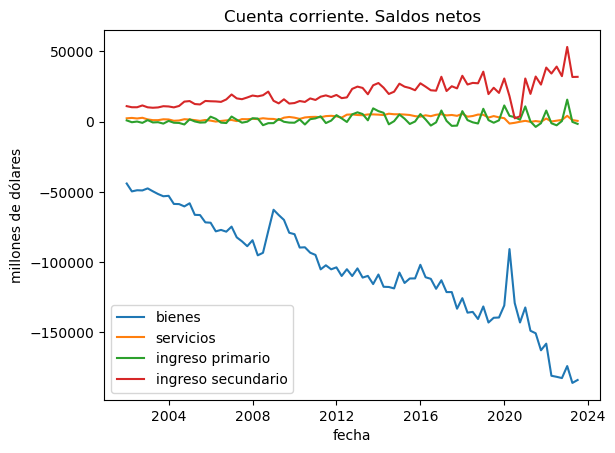

In [10]:
corr_neto_ingsec=corr_debito.iloc[:,4]-corr_credito.iloc[:,0]
corr_neto_serv=corr_debito.iloc[:,3]-corr_credito.iloc[:,3]
corr_neto_ingprim=corr_debito.iloc[:,0]-corr_credito.iloc[:,2]
corr_neto_bienes=corr_debito.iloc[:,2]-corr_credito.iloc[:,1]
plt.plot(x2,corr_neto_bienes,x2,corr_neto_serv,x2,corr_neto_ingprim,x2,corr_neto_ingsec)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta corriente. Saldos netos')
plt.legend(['bienes','servicios','ingreso primario','ingreso secundario'])

plt.savefig('CC_saldosnetos.pdf', format="pdf", bbox_inches="tight")


### 2. Selección de variables explicativas

Dado que en la cuenta de crédito los bienes fueron la subcuenta más grande con 178 mil millones de dólares, se revisó el análisis de exportaciones e importaciones del [atlas de Harvard](https://atlas.cid.harvard.edu/countries/138/export-basket) para México. De acuerdo con dicha base de datos, las principales *exportaciones netas* para México en 2021 fueron en autos y autopartes (~28%), computadoras (~14%), petróleo (~8.3%), otros minerales (~8.5%), así como alimentos, bebidas y agropecuarios (~8%), entre otros. Por ello, se incluyó en el modelo la producción industrial de estos componentes.

Por otro lado, las cuentas de ingresos secundarios  también incluyen los ingresos por remesas, así como para la cuenta de servicios se incluyeron turismo, propiedad intelectual, que son los principales componentes.

Por todo lo anterior, se incluyeron en el modelo las siguientes variables:

* IGAE base 2013, serie original, mensual, publicada por INEGI.
* Ingresos por remesas en millones de dólares, mensual, publicada por Banco de México.
* Tipo de cambio peso-dólar promedio FIX mensual, publicada por banco de México.
* Indice de volumen de la inversión fija bruta,
* INPC general

cuadro de pronóstico de los tres meses del 2023, evaluar RMSE u otros para sep, oct, nov, dic
cuadro los criterios para evaluar

no borrar los códigos de las demás

meter las redes neuronales


Destacan las siguientes características:

1. Debido a que algunas variables están en dólares y otras en pesos, se usa como control el tipo de cambio FIX promedio del periodo
2. Se decidió descargar las series originales para aplicar luego su propio proceso de desestacionalización
3. Dado que las series de balanza de pagos son trimestrales y las variables explicativas son mensuales, se realizó un nowcasting de las series de balanza de pagos

Se plantearon tres posibles modelos de predicción para cuenta corriente:

* con modelos autorregresivos tradicionales
* con modelos de redes neuronales
* con modelos de inferencia bayesianos

### 4. Modelos de predicción para cuenta corriente considerados

#### 4.1. Modelo autoarima

In [11]:
#guardar la versión de nowcast
#df2=pd.DataFrame(pd.concat([explicativas,corr], axis=1))
#df2.to_csv('/Users/1thaliaespana1/Documents/Semestre II/ambientes/sandbox_Python/estancia_investigacion/modelacion_economica/versiones_balanza_pagos/nowcast_bp_230918.csv', index=True, header=True)


#API de FRED
def descargar_fred(serie,fecha_inicio,fecha_fin):
    key_2='fb3e12e05f3753283d1b617eee584598'
    url_2='https://api.stlouisfed.org/fred/series/observations?series_id='+serie+'&api_key='+key_2+'&file_type=json'
    response2 = requests.get(url_2)
    status=response2.status_code
    raw_data = response2.json()
    variable=pd.DataFrame(raw_data['observations'])[['date','value']]
    variable=variable.set_index(pd.to_datetime(list(variable.iloc[:,0]),format="%Y/%m/%d")).drop(['date'],axis=1)
    variable=variable.loc[fecha_inicio:fecha_fin]
    return pd.DataFrame(variable)

#pd.concat([ipi_us.iloc[:,0].apply(lambda x:float(x)),payroll.iloc[:,0].apply(lambda x:float(x))],axis=1)
def a_float(serie):
    return serie.iloc[:,0].apply(lambda x:float(x))





In [12]:
ipi_us=descargar_fred('INDPRO',fecha_inicio,fecha_fin)
payroll=descargar_fred('PAYEMS',fecha_inicio,fecha_fin)
cpi_us=descargar_fred('CPIAUCSL','2001-01-01',fecha_fin)

igae=descargar_banxico('SR16734',fecha_inicio,fecha_fin)
remesas=descargar_banxico('SE27803',fecha_inicio,fecha_fin)
usdmxn_mensual=descargar_banxico('SF17908',fecha_inicio,fecha_fin)
usdmxn_diaria=descargar_banxico('SF43718',fecha_inicio,fecha_fin)
ifb=descargar_banxico('SR17459',fecha_inicio,fecha_fin)
inpc=descargar_banxico('SP1','2001-01-01',fecha_fin)
inpc=inpc.pct_change(12).iloc[12:,:]
cpi_us=a_float(cpi_us).pct_change(12).iloc[12:]
cpi_us=pd.DataFrame(cpi_us)
cpi_us[cpi_us['value']<0]=0.0005

#fondeo es diaria, convertir a mensual
fondeo=descargar_banxico('SF43773',fecha_inicio,fecha_fin)
fondeo=fondeo.set_index(pd.to_datetime(list(fondeo.index),format="%d/%m/%Y")).resample('M').mean()
fondeo=fondeo.set_index([pd.date_range(start=fecha_inicio,end=fecha_fin,freq='MS')])


In [13]:
explicativas=pd.concat([igae,remesas,usdmxn_mensual,ifb,inpc],axis=1).set_index(pd.to_datetime(list(inpc.index),format="%d/%m/%Y"))
explicativas=pd.concat([explicativas,fondeo,a_float(ipi_us),a_float(payroll),cpi_us],axis=1)
explicativas=pd.concat([explicativas,corr.set_index(pd.to_datetime(list(corr.index),format="%d/%m/%Y"))],axis=1).ffill().set_axis(['IGAE','Remesas','USDMXN','Inversión fija bruta','Inflación MX','Tasa de fondeo','Producción industrial EEUU','Nómina no agrícola EEUU','Inflación EEUU','Cuenta corriente MX'],axis='columns')
explicativas1=explicativas.apply(lambda x:np.log(x))

#train_set1, test_set1= np.split(explicativas1, [int(.9 *len(explicativas1))])

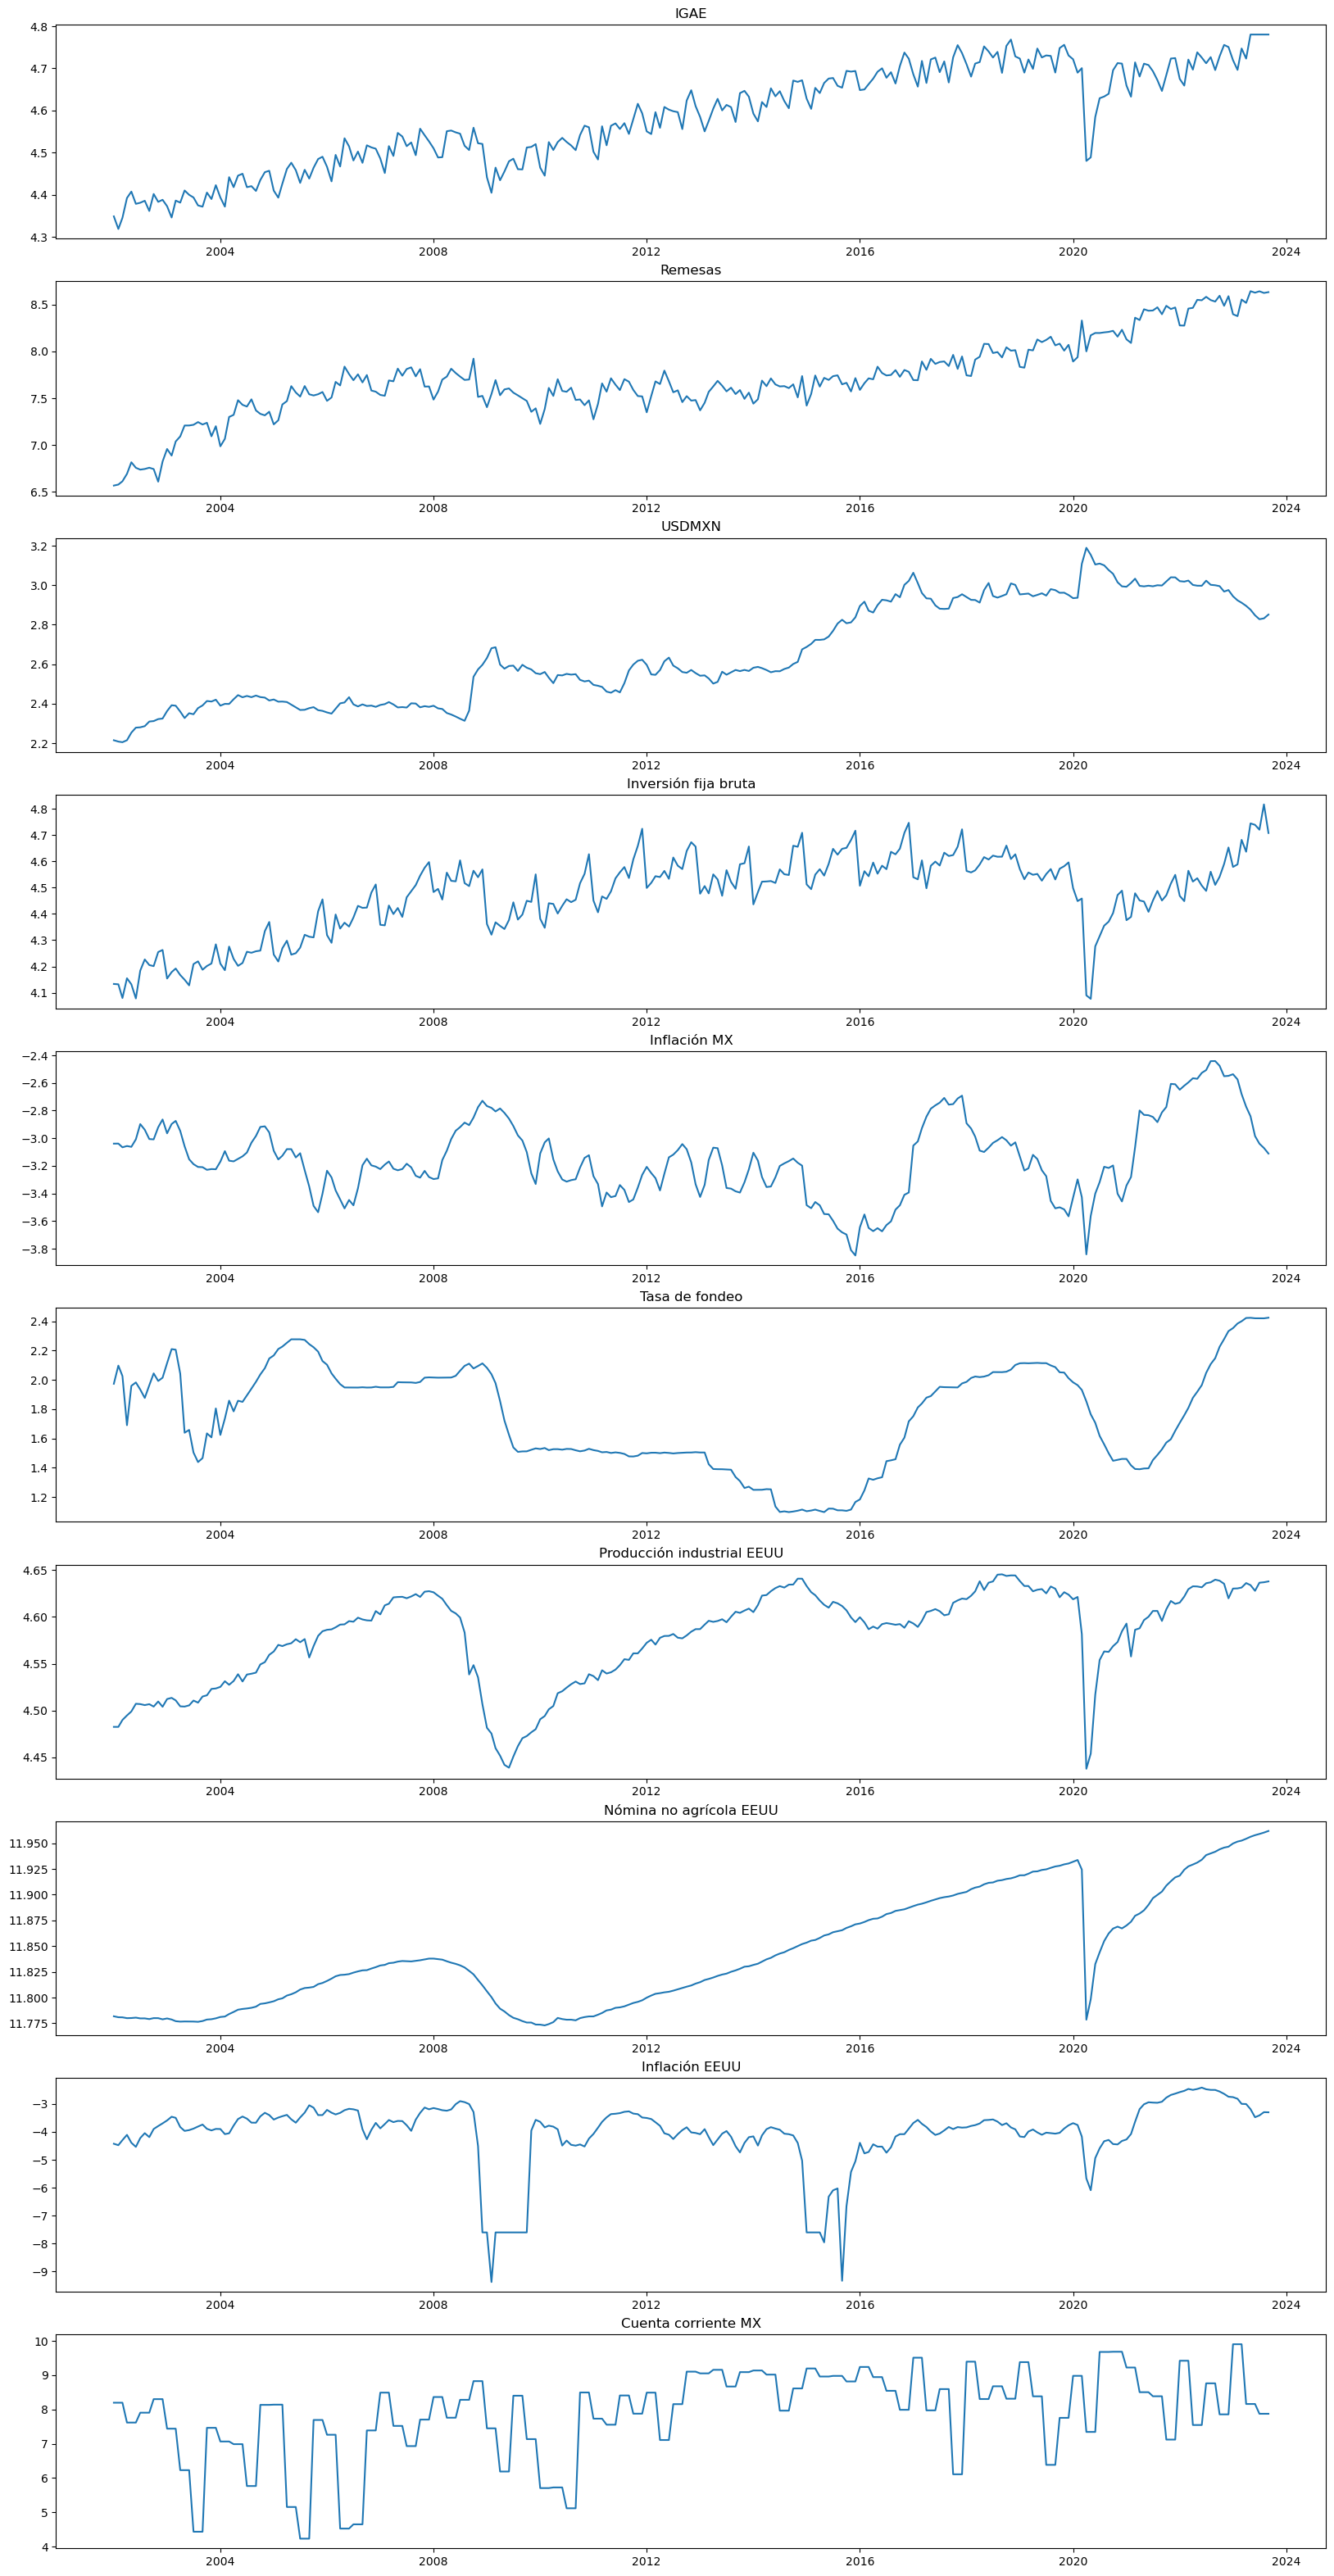

In [14]:
x=pd.to_datetime(list(explicativas1.index),format="%Y/%m/%d")
T00=np.shape(explicativas)[1]

fig, axs = plt.subplots(T00,1, figsize=(20, 40), sharey=False)

for j in range(T00):
    axs[j].plot(x,explicativas1.iloc[:,j])
    axs[j].set_title(explicativas1.columns[j])

plt.show()

Debido a que las variables económicas tienen relación entre sí, es necesario que los modelos ARIMA y los modelos de redes reflejen esta relación, por lo que se incluyeron los rezagos de las variables que estaban significativamente correlacionados con otras variables. Esto se apreció mediante los correlogramas de correlación cruzada, los cuales se muestran a continuación. Estos rezagos también se inbluirán en los modelos de redes, aunque algunos de ellos ya estén incluidos en las convoluciones.

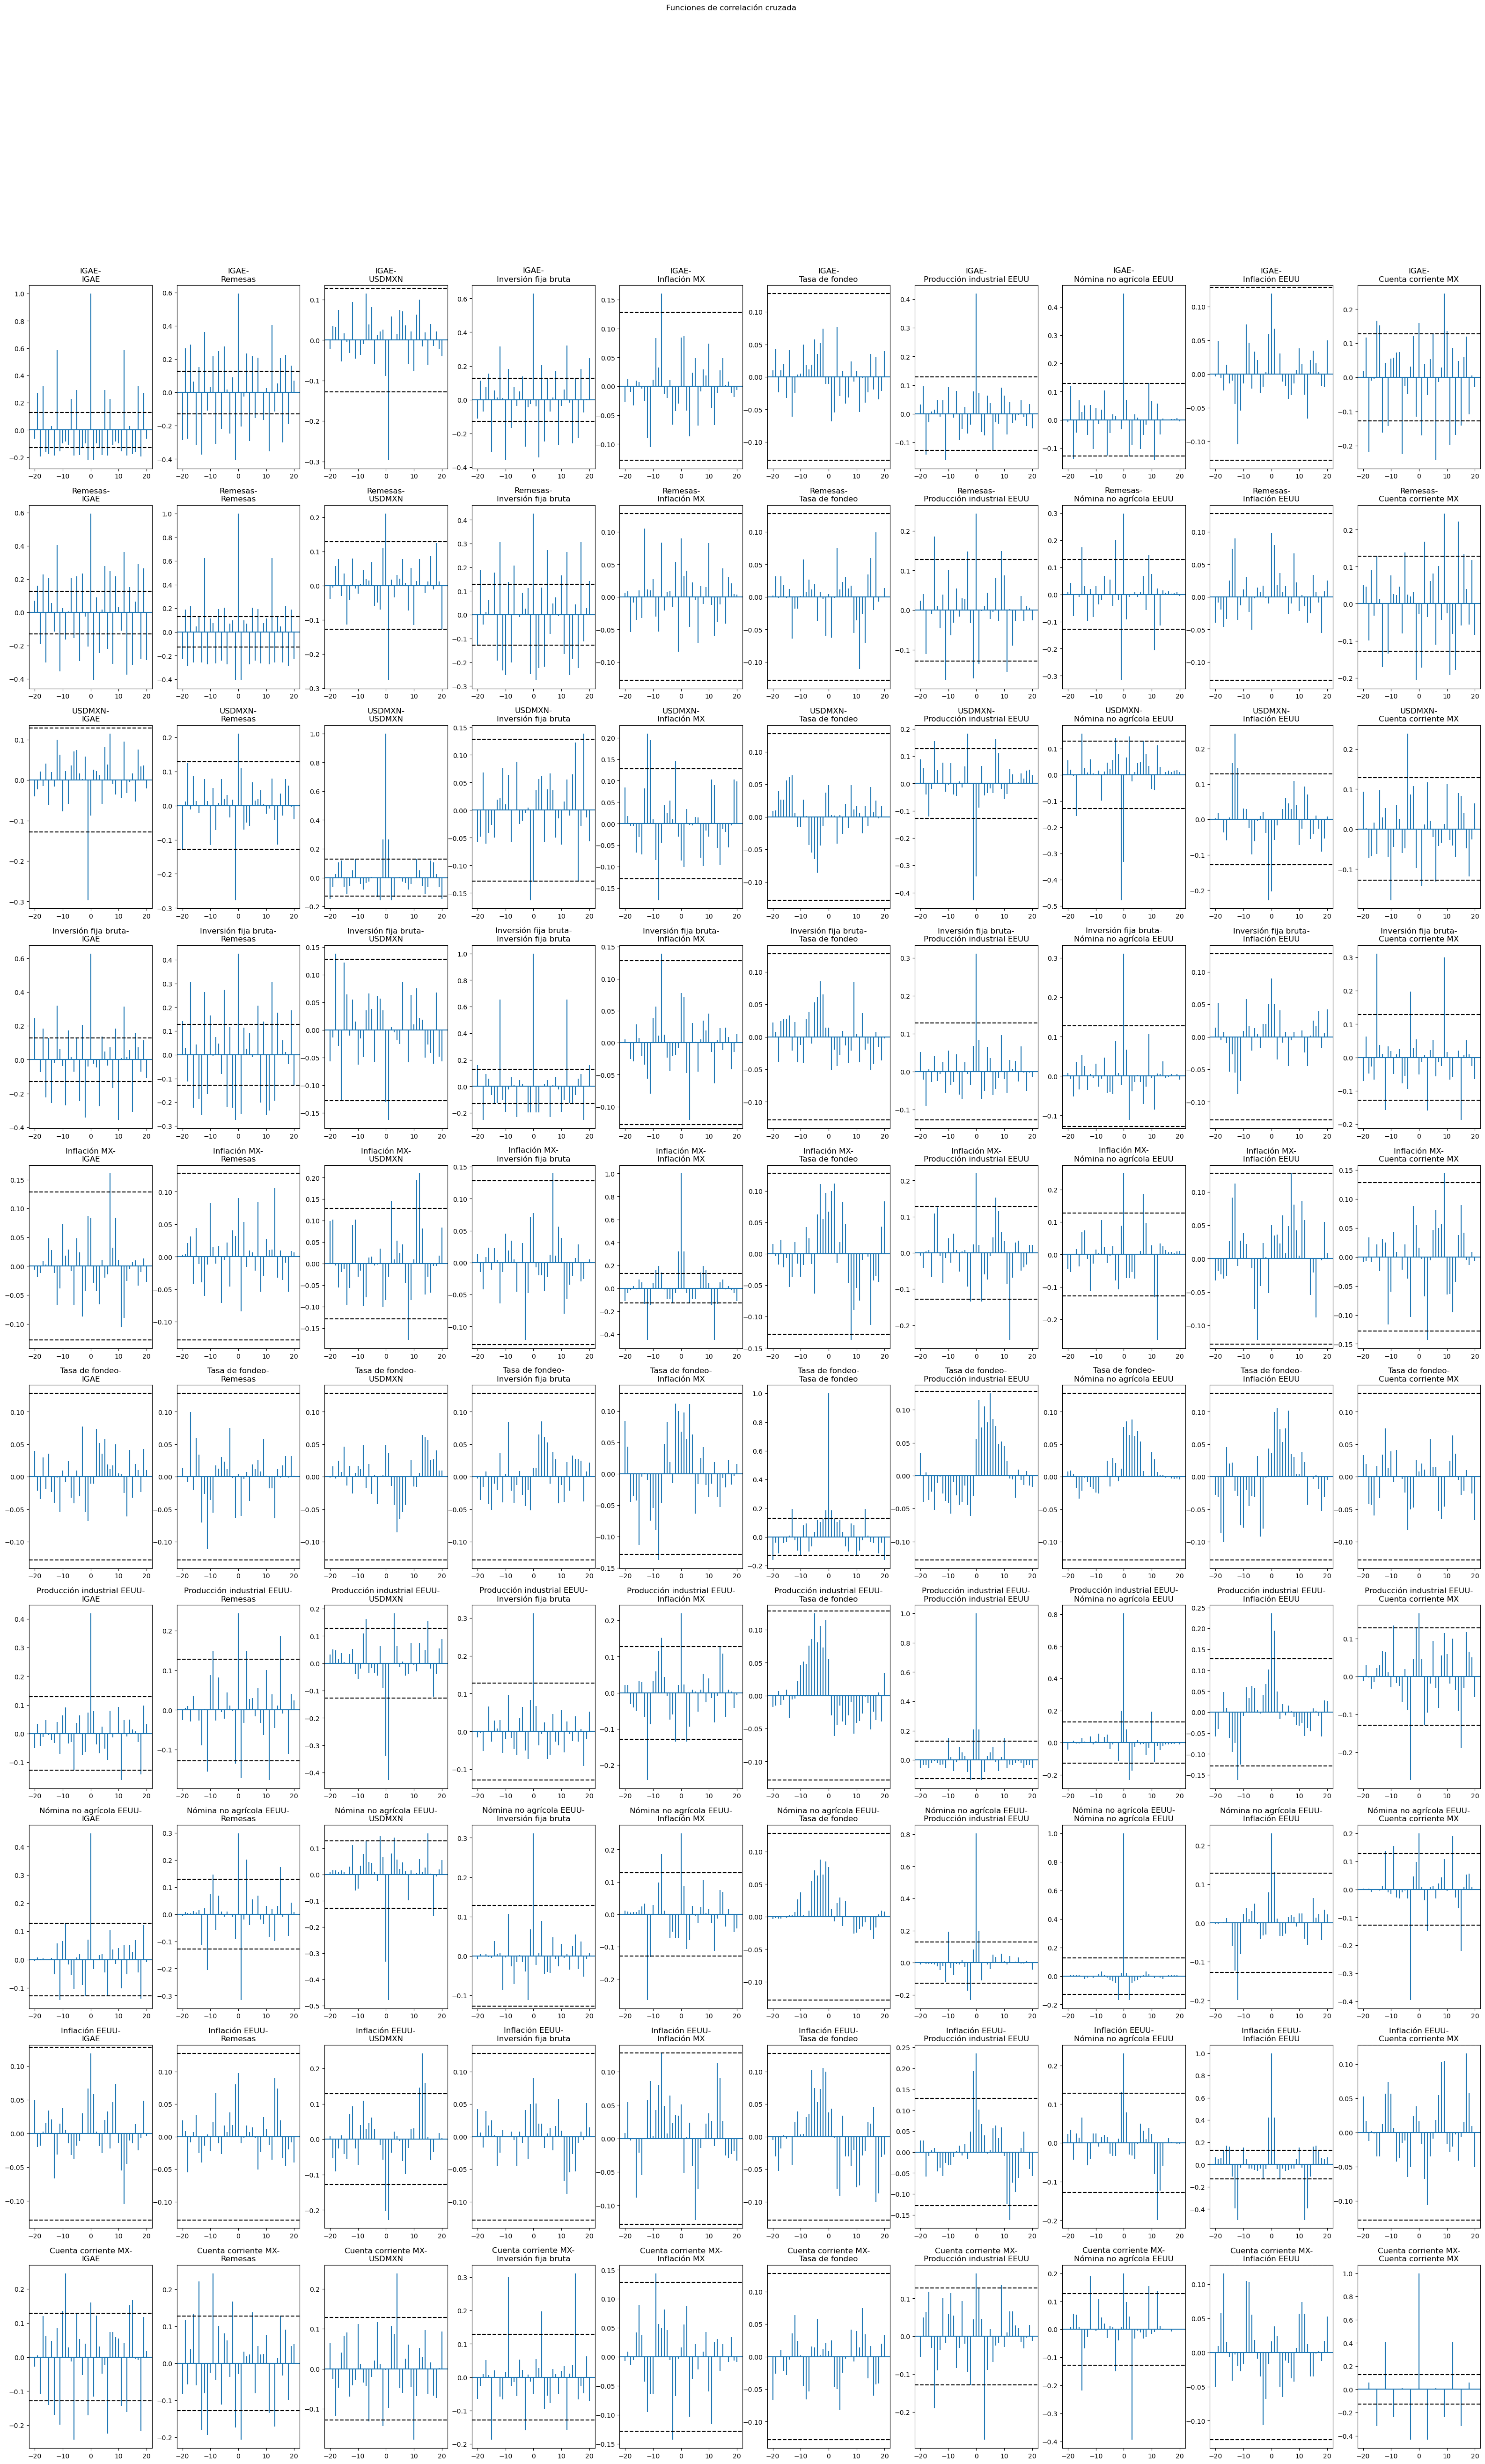

In [17]:
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(explicativas,train_size=0.9, test_size=0.1, shuffle=False)
Tc=train_set.shape[1]
fig,ax= plt.subplots(Tc,Tc,figsize=(40,60))
for i in range(Tc):
    for j in range(Tc):
        x11=train_set[train_set.columns[i]].diff().iloc[2:]
        x12=train_set[train_set.columns[j]].diff().iloc[2:]
        ax[i,j].xcorr(x11, x12, usevlines=True, maxlags=20)
        ax[i,j].axhline(-1.96/np.sqrt(len(train_set)), color='k', ls='--') 
        ax[i,j].axhline(1.96/np.sqrt(len(train_set)), color='k', ls='--')
        ax[i,j].set_title(train_set.columns[i]+'-\n'+train_set.columns[j])
    
    fig.suptitle('Funciones de correlación cruzada')
plt.show()



In [ ]:
"""
Rezagos significativos en correlación cruzada:

l_igae=[2,3,12]
l_remesas=[12,2,8]
l_usdmxn=[1,12]
l_ifb=[1,4,10]
l_inflac=[10]
l_fondeo=[1]
"""

"""def rezagar_cols(df,col,lags):
    for i in range(len(lags)):
        df[col+'.lag('+str(lags[i])+')']=df[col].shift(lags[i])
    return df
def rezagar_set(set):
    rezagar_cols(set,'IGAE',[2,3,12])
    rezagar_cols(set,'Remesas',[12,2,8])
    rezagar_cols(set,'USDMXN',[1,12])
    rezagar_cols(set,'Inversión fija bruta',[1,4,10])
    rezagar_cols(set,'Inflación MX',[10])
    rezagar_cols(set,'Tasa de fondeo',[1])
    return set

explicativas1=rezagar_set(explicativas1)
explicativas1=explicativas1.dropna()
explicativas1.columns"""

#explicativas1.columns

Index(['IGAE', 'Remesas', 'USDMXN', 'Inversión fija bruta', 'Inflación MX',
       'Tasa de fondeo', 'Producción industrial EEUU',
       'Nómina no agrícola EEUU', 'Inflación EEUU', 'Cuenta corriente MX',
       'Remesas.lag(12)', 'Remesas.lag(2)', 'Remesas.lag(8)', 'USDMXN.lag(1)',
       'USDMXN.lag(12)', 'Inversión fija bruta.lag(1)',
       'Inversión fija bruta.lag(4)', 'Inversión fija bruta.lag(10)',
       'Inflación MX.lag(10)', 'Tasa de fondeo.lag(1)', 'IGAE.lag(2)',
       'IGAE.lag(3)', 'IGAE.lag(12)'],
      dtype='object')

### Modelos auto-arima para explicativas

In [18]:
#!pip install pmdarima
#!pip install torch
import pmdarima
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(explicativas1, train_size=0.9, test_size=0.1, shuffle=False)

#auto_arimas_conexp=train_set1.apply(lambda x:pmdarima.arima.auto_arima(x,X=train_set1.drop(x),error_action='ignore', trace=True,suppress_warnings=True, maxiter=5,seasonal=True, m=12))
auto_arimas_sinexp=[]
auto_arimas_conexp=[]

for i in range(T00):
    yest=train_set.iloc[:,i]
    xest=train_set.drop(train_set.columns[i],axis=1)
    auto_arimas_sinexp.append(pmdarima.arima.auto_arima(yest,error_action='ignore',suppress_warnings=True, maxiter=10,with_intercept=True,seasonal=True, m=12))
    auto_arimas_conexp.append(pmdarima.arima.auto_arima(yest,xest,error_action='ignore',suppress_warnings=True, maxiter=10,with_intercept=True,seasonal=True, m=12))
    #results.append({'variable':[explicativas.columns.values[i]],'params':[auto_arimas[i].params()],'pvalues':[auto_arimas[i].pvalues()]},ignore_index=True)

['auto arimas sin variables explicativas',auto_arimas_sinexp,
'auto arimas sin variables explicativas',auto_arimas_conexp]

['auto arimas sin variables explicativas',
 [ARIMA(maxiter=10, order=(2, 1, 0), scoring_args={},
        seasonal_order=(2, 0, 2, 12), suppress_warnings=True,
        with_intercept=False),
  ARIMA(maxiter=10, order=(2, 1, 2), scoring_args={},
        seasonal_order=(1, 0, 1, 12), suppress_warnings=True),
  ARIMA(maxiter=10, order=(0, 1, 1), scoring_args={},
        seasonal_order=(0, 0, 0, 12), suppress_warnings=True,
        with_intercept=False),
  ARIMA(maxiter=10, order=(0, 1, 2), scoring_args={},
        seasonal_order=(1, 0, 1, 12), suppress_warnings=True,
        with_intercept=False),
  ARIMA(maxiter=10, order=(1, 0, 1), scoring_args={},
        seasonal_order=(0, 0, 1, 12), suppress_warnings=True),
  ARIMA(maxiter=10, order=(0, 1, 0), scoring_args={},
        seasonal_order=(0, 0, 0, 12), suppress_warnings=True,
        with_intercept=False),
  ARIMA(maxiter=10, order=(0, 1, 3), scoring_args={},
        seasonal_order=(0, 0, 0, 12), suppress_warnings=True,
        with_interc

In [19]:

def predicciones_calculo(auto_arimas,num_periodos,Xest=None):
    T1=np.shape(train_set)[1]
    forward1=pd.DataFrame({})
    for i in range(T00):
        forward1=pd.concat([forward1,auto_arimas[i].predict(num_periodos)],axis=1)
    forward1=forward1.set_axis([train_set.columns.values[:T00]], axis='columns').set_index(pd.date_range(train_set.index[-1],periods=num_periodos,freq='m'))
    return forward1

def autoarima_conexp(auto_arimas,num_periodos,Xest):
    T1=np.shape(explicativas1)[1]
    forward1=pd.DataFrame({})
    for i in range(T00):
        regresores=Xest.drop(Xest.columns[i],axis=1)
        forward1=pd.concat([forward1,auto_arimas[i].predict(num_periodos,regresores)],axis=1)
    forward1=forward1.set_axis([explicativas1.columns.values[:T00]], axis='columns').set_index(pd.date_range(train_set.index[-1],periods=num_periodos,freq='m'))
    return forward1 

predicciones_sinexp=predicciones_calculo(auto_arimas_sinexp,test_set.shape[0])
predicciones_sinexp.tail()

IGAE   Remesas    USDMXN Inversión fija bruta Inflación MX  \
2023-04-30  4.727527  8.756576  2.997056             4.395979    -3.223601   
2023-05-31  4.739894  8.755051  2.997056             4.416458    -3.221289   
2023-06-30  4.747714  8.756609  2.997056             4.436072    -3.219169   
2023-07-31  4.752259  8.769919  2.997056             4.455487    -3.217226   
2023-08-31  4.734663  8.757394  2.997056             4.452658    -3.215444   

           Tasa de fondeo Producción industrial EEUU Nómina no agrícola EEUU  \
2023-04-30       1.396245                   4.598329               11.890142   
2023-05-31       1.396245                   4.598329               11.890142   
2023-06-30       1.396245                   4.598329               11.890142   
2023-07-31       1.396245                   4.598329               11.890142   
2023-08-31       1.396245                   4.598329               11.890142   

           Inflación EEUU Cuenta corriente MX  
2023-04-30      -4.157142            8.813460  
2023-05-31      -4.159793            8.813460  
2023-06-30      -4.162153            9.073389  
2023-07-31      -4.164255            9.073389  
2023-08-31      -4.166127            9.073389

### Predicciones de modelos sin regresores

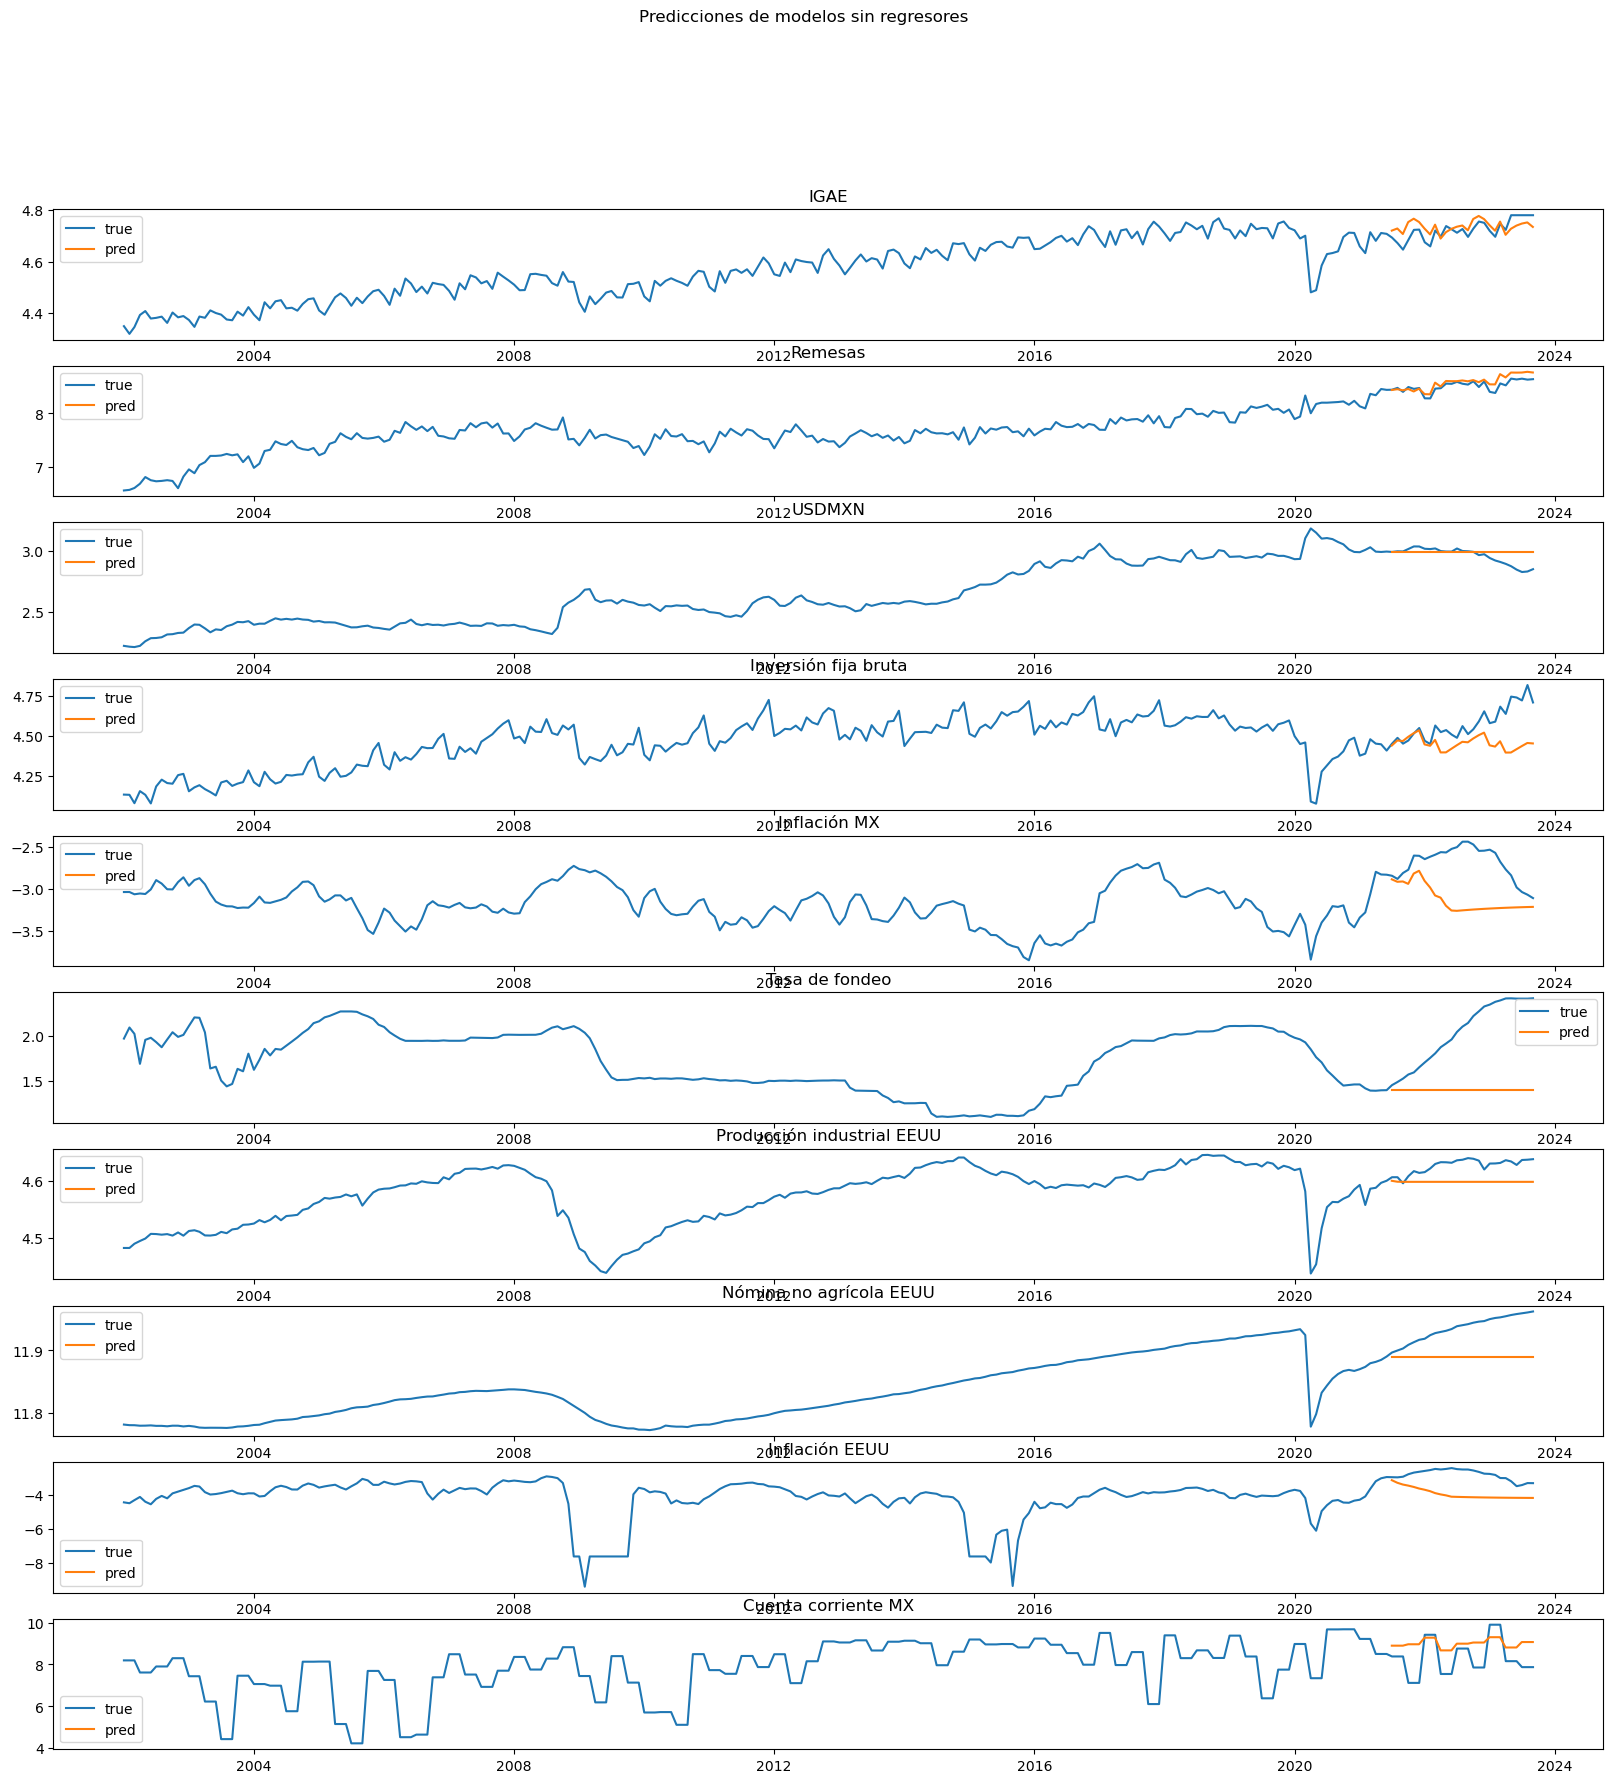

[['IGAE', ('IGAE',)],
 ['Remesas', ('Remesas',)],
 ['USDMXN', ('USDMXN',)],
 ['Inversión fija bruta', ('Inversión fija bruta',)],
 ['Inflación MX', ('Inflación MX',)],
 ['Tasa de fondeo', ('Tasa de fondeo',)],
 ['Producción industrial EEUU', ('Producción industrial EEUU',)],
 ['Nómina no agrícola EEUU', ('Nómina no agrícola EEUU',)],
 ['Inflación EEUU', ('Inflación EEUU',)],
 ['Cuenta corriente MX', ('Cuenta corriente MX',)]]

<Figure size 640x480 with 0 Axes>

In [20]:
fig, axs = plt.subplots(T00,1, figsize=(20, 20), sharey=False)
x1=explicativas1.index
xk=predicciones_sinexp.index
check0=[]
for j in range(T00):
    axs[j].plot(x1,explicativas1.iloc[:,j],xk,predicciones_sinexp.iloc[:,j])
    axs[j].legend(['true','pred'])
    axs[j].set_title(explicativas1.columns[j])
    check0.append([explicativas1.columns[j],predicciones_sinexp.columns[j]])
fig.suptitle('Predicciones de modelos sin regresores')
plt.show()

plt.savefig('modelos_ARIMA.pdf', format="pdf", bbox_inches="tight")
check0

In [21]:

#estimadores=pd.DataFrame(auto_arimas).apply(lambda x:x.params())
#estimadores
results=pd.DataFrame({})
for num_var in range(7):
    #results.append({'params':[auto_arimas[i].params()],'pvalues':[auto_arimas[i].pvalues()]},ignore_index=True)
    A=pd.concat({explicativas.columns.values[num_var]:pd.concat([round(auto_arimas_sinexp[num_var].params(),2),round(auto_arimas_sinexp[num_var].pvalues(),3)],keys=['params','pvalues'],axis=1)})
    results=pd.concat([results,A])

results


params  pvalues
IGAE                       ar.L1       -0.27    0.000
                           ar.L2       -0.23    0.000
                           ar.S.L12     0.50    0.988
                           ar.S.L24     0.42    0.989
                           ma.S.L12    -0.23    0.994
                           ma.S.L24    -0.30    0.989
                           sigma2       0.00    0.000
Remesas                    intercept    0.00    0.216
                           ar.L1       -0.78    0.006
                           ar.L2       -0.14    0.372
                           ma.L1        0.30    0.278
                           ma.L2       -0.29    0.217
                           ar.S.L12     0.87    0.000
                           ma.S.L12    -0.47    0.000
                           sigma2       0.00    0.000
USDMXN                     ma.L1        0.34    0.000
                           sigma2       0.00    0.000
Inversión fija bruta       ma.L1       -0.26    0.000
                           ma.L2       -0.17    0.001
                           ar.S.L12     0.90    0.000
                           ma.S.L12    -0.59    0.000
                           sigma2       0.00    0.000
Inflación MX               intercept   -0.27    0.004
                           ar.L1        0.92    0.000
                           ma.L1        0.35    0.000
                           ma.S.L12    -0.63    0.000
                           sigma2       0.00    0.000
Tasa de fondeo             sigma2       0.00    0.000
Producción industrial EEUU ma.L1        0.24    0.000
                           ma.L2       -0.13    0.000
                           ma.L3       -0.09    0.037
                           sigma2       0.00    0.000

### Predicciones de modelos con regresores

In [22]:
predicciones_conexp=autoarima_conexp(auto_arimas_conexp,test_set.shape[0],test_set)
predicciones_conexp.tail()

IGAE   Remesas    USDMXN Inversión fija bruta Inflación MX  \
2023-04-30  4.757481  8.308452  3.052512             4.675529    -3.152091   
2023-05-31  4.748151  8.244231  3.074861             4.681214    -3.126945   
2023-06-30  4.737790  8.198940  3.088922             4.699747    -3.149908   
2023-07-31  4.758141  8.177983  3.039302             4.718077    -3.162991   
2023-08-31  4.728506  8.207099  3.118075             4.716062    -3.164338   

           Tasa de fondeo Producción industrial EEUU Nómina no agrícola EEUU  \
2023-04-30       1.659443                   4.681952               11.921740   
2023-05-31       1.624678                   4.686384               11.922200   
2023-06-30       1.632485                   4.691860               11.955224   
2023-07-31       1.660604                   4.688885               11.935829   
2023-08-31       1.655216                   4.688686               11.970210   

           Inflación EEUU Cuenta corriente MX  
2023-04-30      -4.134450            7.477731  
2023-05-31      -4.092379            7.334832  
2023-06-30      -3.930994            7.448867  
2023-07-31      -4.135599            7.372043  
2023-08-31      -3.956789            7.416087

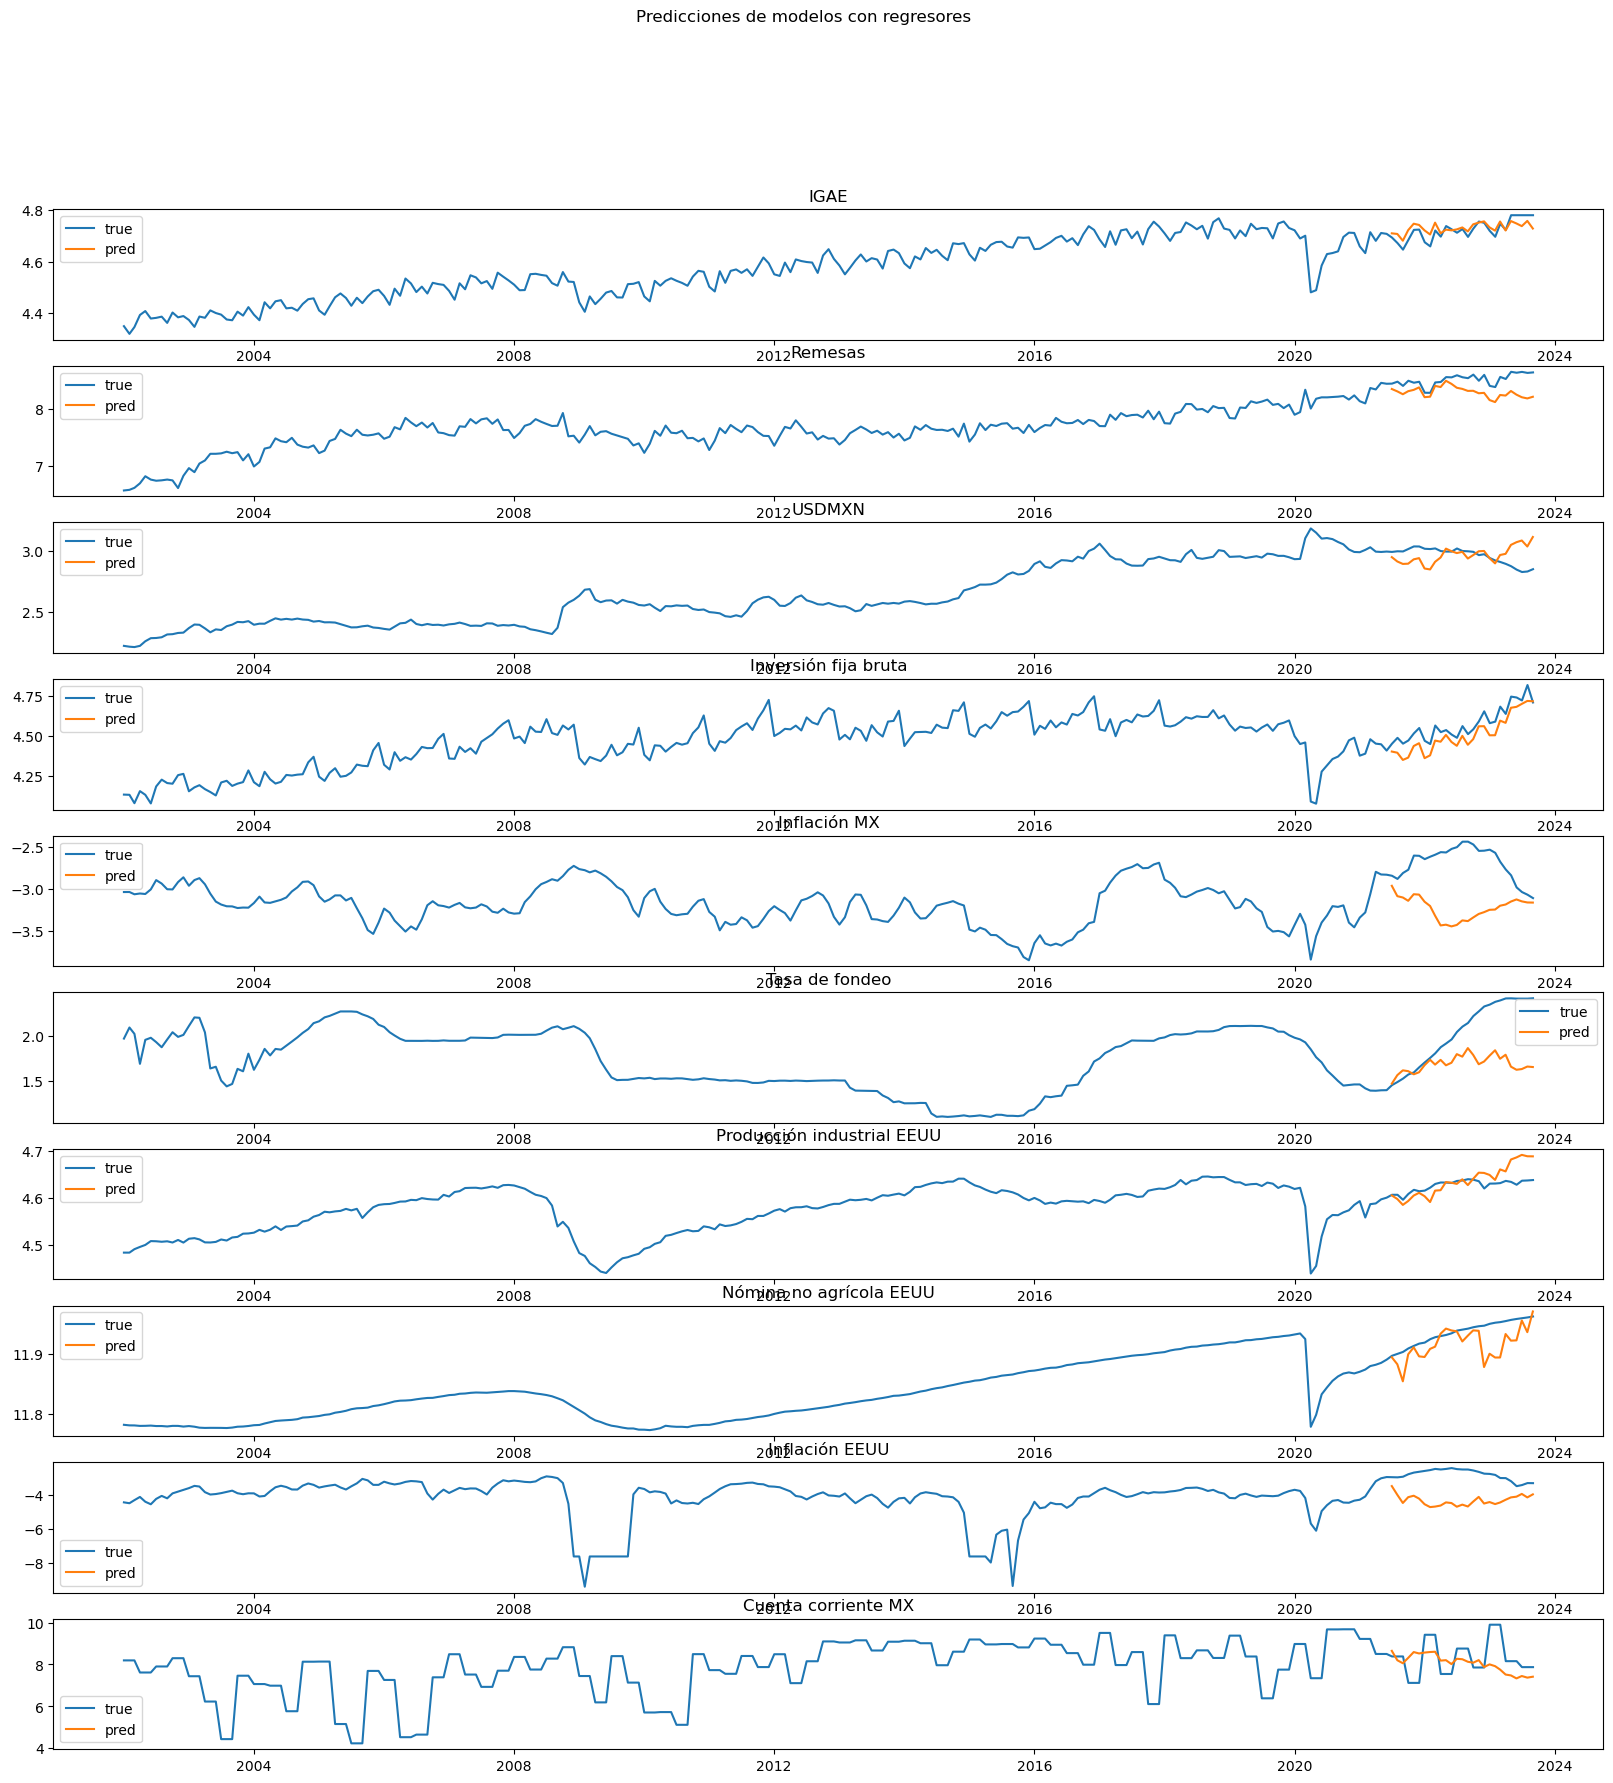

[['IGAE', ('IGAE',)],
 ['Remesas', ('Remesas',)],
 ['USDMXN', ('USDMXN',)],
 ['Inversión fija bruta', ('Inversión fija bruta',)],
 ['Inflación MX', ('Inflación MX',)],
 ['Tasa de fondeo', ('Tasa de fondeo',)],
 ['Producción industrial EEUU', ('Producción industrial EEUU',)],
 ['Nómina no agrícola EEUU', ('Nómina no agrícola EEUU',)],
 ['Inflación EEUU', ('Inflación EEUU',)],
 ['Cuenta corriente MX', ('Cuenta corriente MX',)]]

In [23]:
fig, axs = plt.subplots(T00,1, figsize=(20, 20), sharey=False)
xk=predicciones_conexp.index
check0=[]
for j in range(T00):
    axs[j].plot(x1,explicativas1.iloc[:,j],xk,predicciones_conexp.iloc[:,j])
    axs[j].legend(['true','pred'])
    axs[j].set_title(explicativas1.columns[j])
    check0.append([explicativas1.columns[j],predicciones_conexp.columns[j]])
fig.suptitle('Predicciones de modelos con regresores')
plt.show()

#plt.savefig('modelos_ARIMA.pdf', format="pdf", bbox_inches="tight")
check0

In [24]:

#estimadores=pd.DataFrame(auto_arimas).apply(lambda x:x.params())
#estimadores
results=pd.DataFrame({})
for num_var in range(7,8):
    #results.append({'params':[auto_arimas[i].params()],'pvalues':[auto_arimas[i].pvalues()]},ignore_index=True)
    A=pd.concat({explicativas1.columns.values[num_var]:pd.concat([round(auto_arimas_conexp[num_var].params(),2),round(auto_arimas_conexp[num_var].pvalues(),3)],keys=['params','pvalues'],axis=1)})
    results=pd.concat([results,A])

results


params  pvalues
Nómina no agrícola EEUU IGAE                          0.35    0.001
                        Remesas                      -0.04    0.140
                        USDMXN                        0.03    0.550
                        Inversión fija bruta         -0.26    0.000
                        Inflación MX                 -0.10    0.000
                        Tasa de fondeo               -0.01    0.730
                        Producción industrial EEUU    2.48    0.000
                        Inflación EEUU               -0.00    0.983
                        Cuenta corriente MX          -0.01    0.000
                        ar.L1                         0.89    0.000
                        sigma2                        0.00    0.000

Se observa que algunas variables tienen un modelo con mejor desempeño cuando no se incorporan los regresores, por lo que se seleccionará el mejor modelo para las variables partiendo de los modelos que tienen mejor desempeño sin regresores, con posteriores iteraciones. 

In [25]:
from sklearn.metrics import mean_squared_error

rmses=[['variable','sin regresores','con regresores']]
#RMSE ARIMAS
for i in range(T00):
    rmses.append([test_set.columns[i],np.round(np.sqrt(mean_squared_error(test_set.iloc[:,i],predicciones_sinexp.iloc[:,i])),4),np.round(np.sqrt(mean_squared_error(test_set.iloc[:,i],predicciones_conexp.iloc[:,i])),4)])
pd.DataFrame(rmses).set_index(0)

1               2
0                                                         
variable                    sin regresores  con regresores
IGAE                                0.0358          0.0265
Remesas                             0.0917          0.2491
USDMXN                              0.0741          0.1233
Inversión fija bruta                0.1665          0.0737
Inflación MX                        0.5057           0.613
Tasa de fondeo                      0.7316           0.464
Producción industrial EEUU          0.0307          0.0269
Nómina no agrícola EEUU             0.0495           0.029
Inflación EEUU                      1.2011          1.6124
Cuenta corriente MX                 0.9816          0.9491

In [26]:
def regresores(which_set):
    x_igae=which_set[['Remesas','Inversión fija bruta','Producción industrial EEUU']]
    x_remesas=None
    x_usdmxn=which_set[['Remesas','Tasa de fondeo','Producción industrial EEUU','Inflación EEUU']]
    x_ifb=which_set[['IGAE','Remesas','Tasa de fondeo','Producción industrial EEUU']]
    x_infMX=which_set[['IGAE','USDMXN','Producción industrial EEUU']]
    x_infEU=which_set[['IGAE','Remesas','Inversión fija bruta','Producción industrial EEUU']]
    x_fondeo=which_set[['Remesas','USDMXN','Inversión fija bruta']]
    x_prodEU=which_set[['IGAE','Remesas','USDMXN','Inversión fija bruta','Inflación MX','Tasa de fondeo']]
    x_nfp=which_set[['USDMXN','Inflación MX','Producción industrial EEUU','Inflación EEUU','Cuenta corriente MX']]
    x_ctacor=None
    return [x_igae,x_remesas,x_usdmxn,x_ifb,x_infMX,x_fondeo,x_prodEU,x_nfp,x_infEU,x_ctacor]

def regresores1(which_set):
    x_igae=which_set
    x_remesas=None
    x_usdmxn=which_set
    x_ifb=which_set
    x_infMX=which_set
    x_infEU=which_set
    x_fondeo=which_set
    x_prodEU=which_set
    x_nfp=which_set
    x_ctacor=None
    return [x_igae,x_remesas,x_usdmxn,x_ifb,x_infMX,x_fondeo,x_prodEU,x_nfp,x_infEU,x_ctacor]

auto_arimas_revisado=[]
for i in range(T00):
    auto_arimas_revisado.append(pmdarima.arima.auto_arima(train_set.iloc[:,i],regresores(train_set)[i],error_action='ignore',suppress_warnings=True, maxiter=10,with_intercept=True,seasonal=True, m=12))

In [27]:
test_pred=pd.DataFrame({})
for i in range(T00):
    test_pred=pd.concat([test_pred,auto_arimas_revisado[i].predict(test_set.shape[0],regresores(test_set)[i])],axis=1)

test_pred=test_pred.set_axis([test_set.columns.values[:T00]], axis='columns')
test_pred.tail()

IGAE   Remesas    USDMXN Inversión fija bruta  \
2023-05-01 00:00:00  4.849725  8.756576  3.146124             4.495774   
2023-06-01 00:00:00  4.845390  8.755051  3.153557             4.481124   
2023-07-01 00:00:00  4.844552  8.756609  3.152597             4.491245   
2023-08-01 00:00:00  4.867605  8.769919  3.153933             4.505918   
2023-09-01 00:00:00  4.828051  8.757394  3.157520             4.510825   

                    Inflación MX Tasa de fondeo Producción industrial EEUU  \
2023-05-01 00:00:00    -3.258510       1.480788                   4.690120   
2023-06-01 00:00:00    -3.252354       1.498861                   4.698219   
2023-07-01 00:00:00    -3.252123       1.516457                   4.716472   
2023-08-01 00:00:00    -3.250058       1.498796                   4.694939   
2023-09-01 00:00:00    -3.248919       1.514028                   4.726291   

                    Nómina no agrícola EEUU Inflación EEUU Cuenta corriente MX  
2023-05-01 00:00:00               11.972393      -3.589327            8.813460  
2023-06-01 00:00:00               11.969843      -3.623804            8.813460  
2023-07-01 00:00:00               11.996870      -3.635617            9.073389  
2023-08-01 00:00:00               11.999731      -3.472925            9.073389  
2023-09-01 00:00:00               12.005409      -3.669055            9.073389

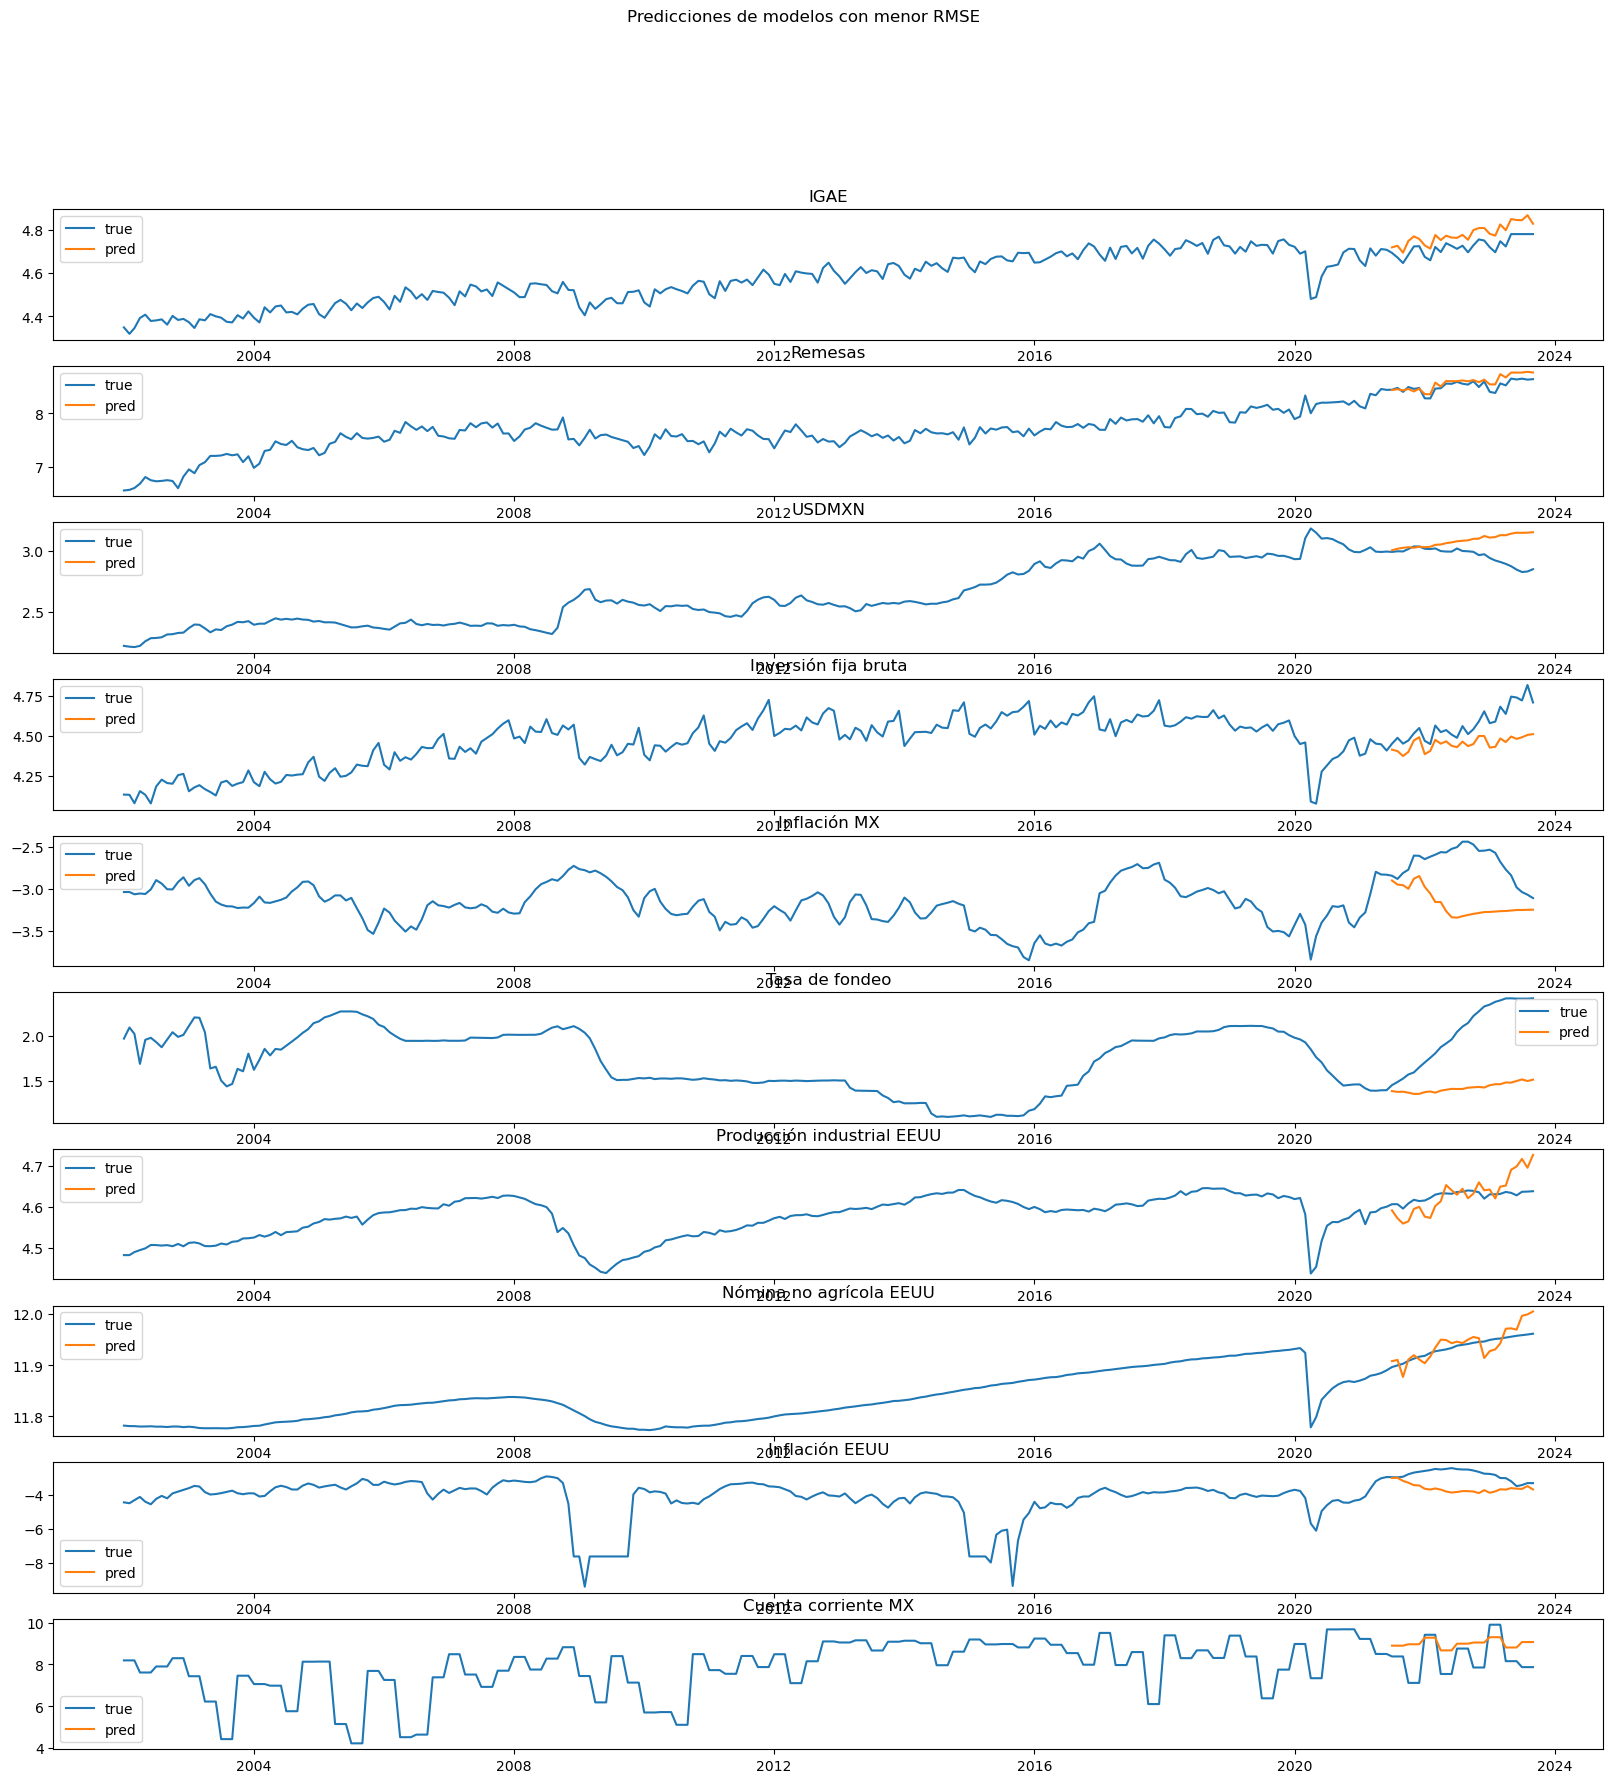

[['IGAE', ('IGAE',)],
 ['Remesas', ('Remesas',)],
 ['USDMXN', ('USDMXN',)],
 ['Inversión fija bruta', ('Inversión fija bruta',)],
 ['Inflación MX', ('Inflación MX',)],
 ['Tasa de fondeo', ('Tasa de fondeo',)],
 ['Producción industrial EEUU', ('Producción industrial EEUU',)],
 ['Nómina no agrícola EEUU', ('Nómina no agrícola EEUU',)],
 ['Inflación EEUU', ('Inflación EEUU',)],
 ['Cuenta corriente MX', ('Cuenta corriente MX',)]]

<Figure size 640x480 with 0 Axes>

In [28]:
fig, axs = plt.subplots(T00,1, figsize=(20, 20), sharey=False)
xk=test_pred.index
check0=[]
for j in range(T00):
    axs[j].plot(x1,explicativas1.iloc[:,j],xk,test_pred.iloc[:,j])
    axs[j].legend(['true','pred'])
    axs[j].set_title(explicativas1.columns[j])
    check0.append([explicativas1.columns[j],predicciones_conexp.columns[j]])
fig.suptitle('Predicciones de modelos con menor RMSE')
plt.show()

plt.savefig('modelos_ARIMA.pdf', format="pdf", bbox_inches="tight")
check0

In [29]:
rmses=[['variable','modelos seleccionados']]
T00=test_set.shape[1]
#RMSE ARIMAS
for i in range(T00):
    
    rmses.append([test_set.columns[i],np.round(np.sqrt(mean_squared_error(test_set.iloc[:,i],test_pred.iloc[:,i])),4)])
pd.DataFrame(rmses).set_index(0)

1
0                                                
variable                    modelos seleccionados
IGAE                                       0.0584
Remesas                                    0.0917
USDMXN                                     0.1646
Inversión fija bruta                        0.143
Inflación MX                                0.553
Tasa de fondeo                              0.687
Producción industrial EEUU                 0.0379
Nómina no agrícola EEUU                    0.0194
Inflación EEUU                             0.9212
Cuenta corriente MX                        0.9816

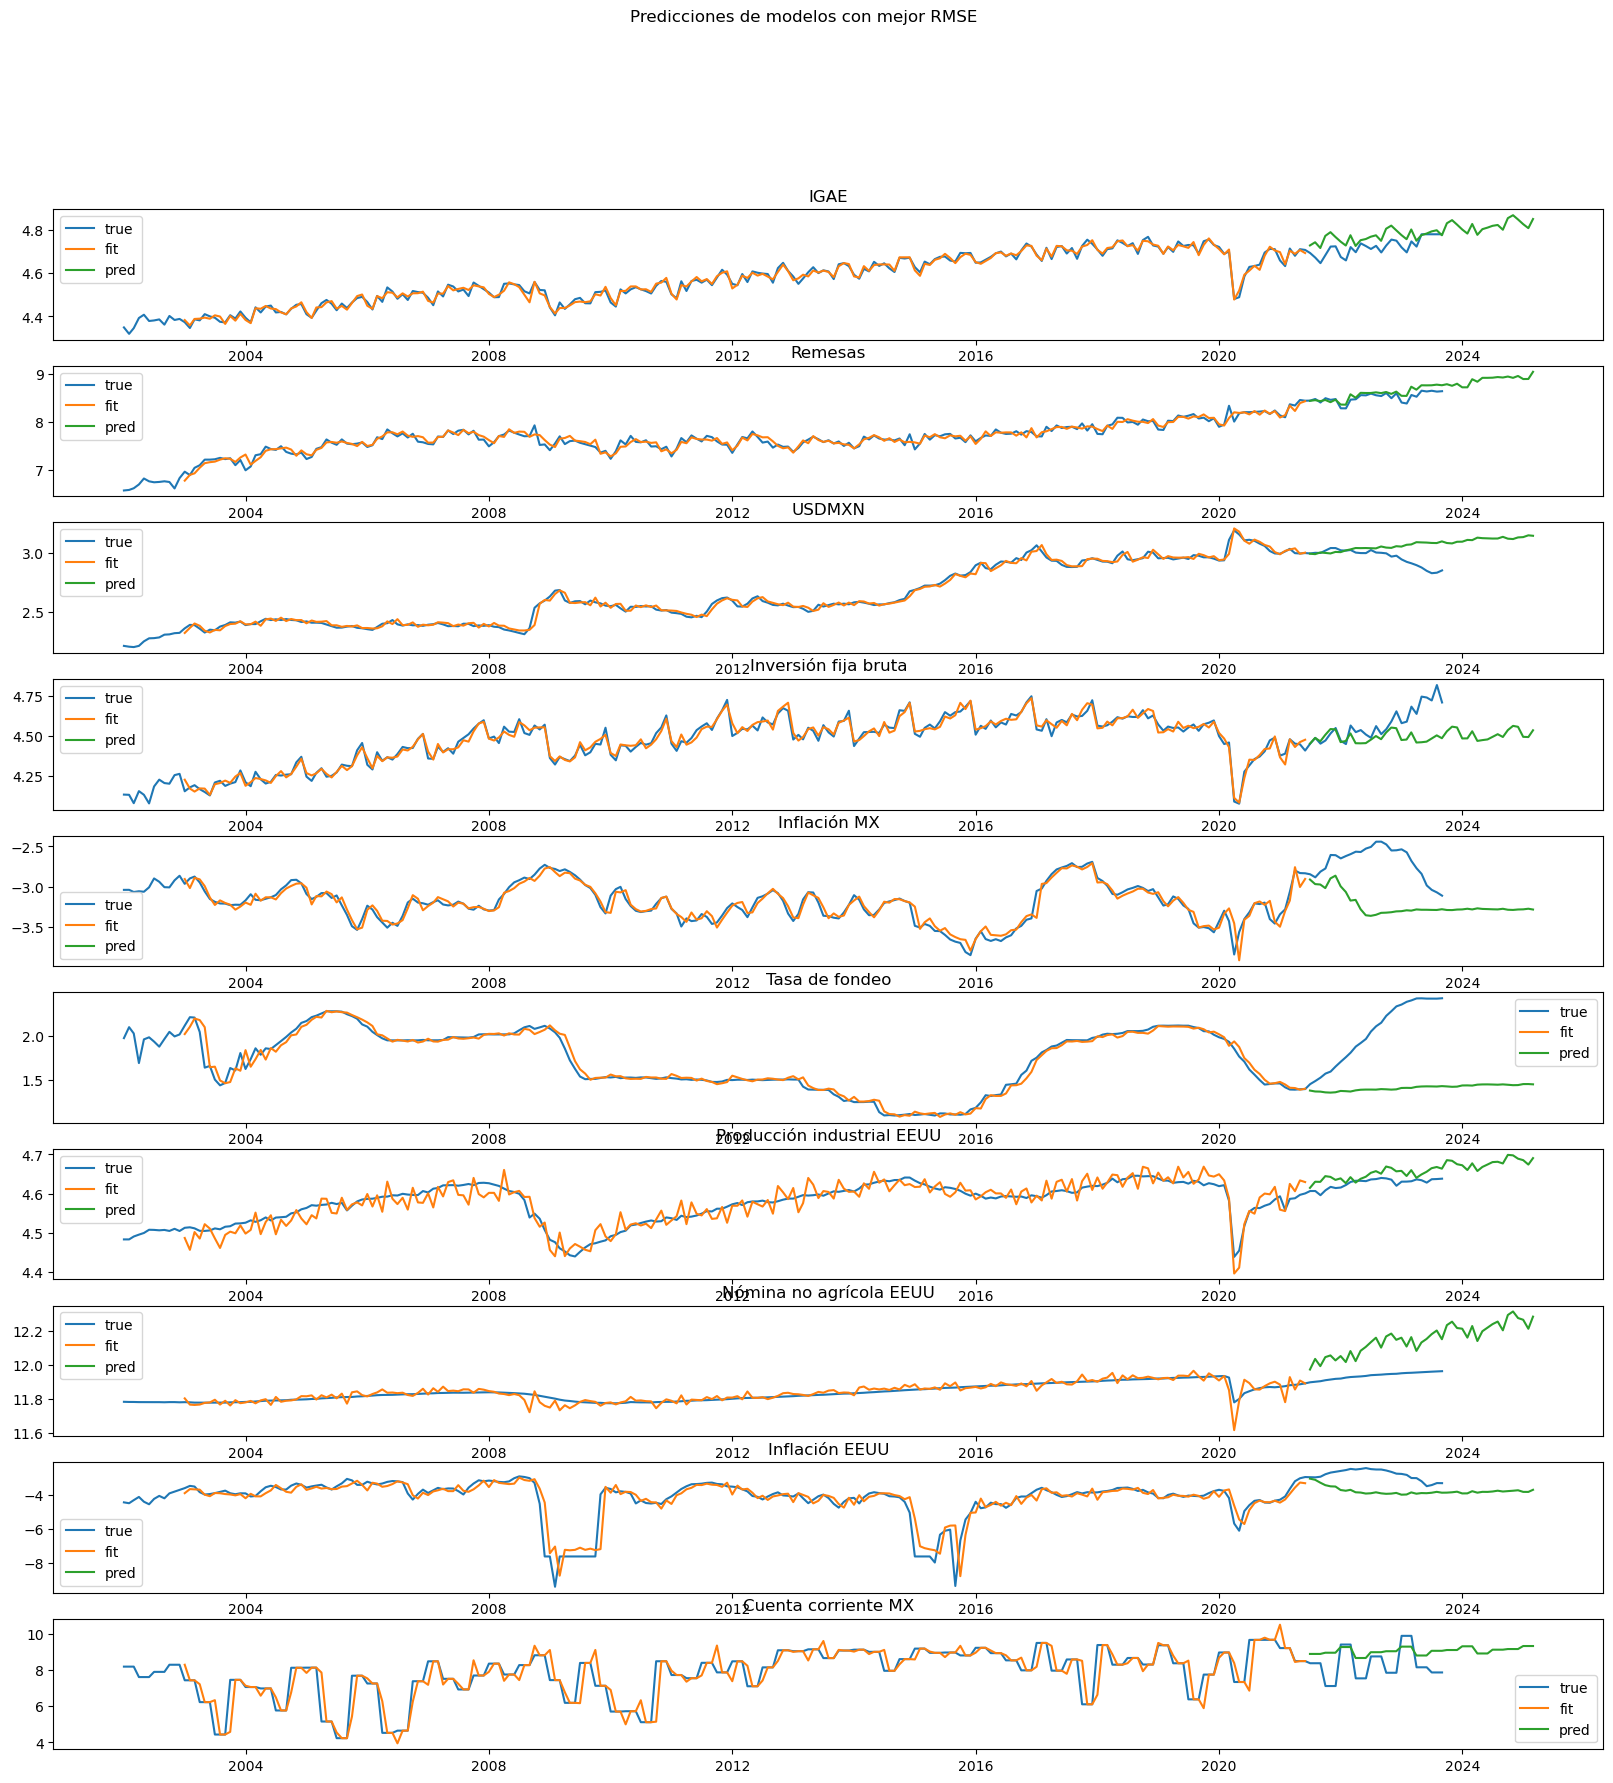

[['IGAE', ('IGAE',)],
 ['Remesas', ('Remesas',)],
 ['USDMXN', ('USDMXN',)],
 ['Inversión fija bruta', ('Inversión fija bruta',)],
 ['Inflación MX', ('Inflación MX',)],
 ['Tasa de fondeo', ('Tasa de fondeo',)],
 ['Producción industrial EEUU', ('Producción industrial EEUU',)],
 ['Nómina no agrícola EEUU', ('Nómina no agrícola EEUU',)],
 ['Inflación EEUU', ('Inflación EEUU',)],
 ['Cuenta corriente MX', ('Cuenta corriente MX',)]]

In [30]:

def autoarima_seleccion(auto_arimas,num_periodos,Xest):
    T1=np.shape(explicativas1)[1]
    forward1=pd.DataFrame({})
    regresor=regresores(Xest)
    for i in range(T00):
        
        forward1=pd.concat([forward1,auto_arimas[i].predict(num_periodos,regresor[i])],axis=1)
    forward1=forward1.set_axis([explicativas1.columns.values[:T00]], axis='columns').set_index(pd.date_range(train_set.index[-1],periods=num_periodos,freq='m'))
    return forward1  

predicciones_sinexp2=predicciones_calculo(auto_arimas_sinexp,len(predicciones_sinexp)+18)
predicciones_seleccion=autoarima_seleccion(auto_arimas_revisado,len(predicciones_sinexp2),predicciones_sinexp2)

for i in range(1):
    predicciones_seleccion=autoarima_seleccion(auto_arimas_revisado,len(predicciones_sinexp2),predicciones_seleccion)

fig, axs = plt.subplots(T00,1, figsize=(20, 20), sharey=False)
check0=[]
for j in range(T00):
    fits=auto_arimas_revisado[j].predict_in_sample(regresores(train_set)[i],axis=1).iloc[12:]
    axs[j].plot(x1,explicativas1.iloc[:,j],fits.index,fits,predicciones_seleccion.index,predicciones_seleccion.iloc[:,j])
    axs[j].legend(['true','fit','pred'])
    axs[j].set_title(explicativas1.columns[j])
    check0.append([explicativas1.columns[j],predicciones_seleccion.columns[j]])
fig.suptitle('Predicciones de modelos con mejor RMSE')
plt.show()

#plt.savefig('modelos_ARIMA.pdf', format="pdf", bbox_inches="tight")
check0

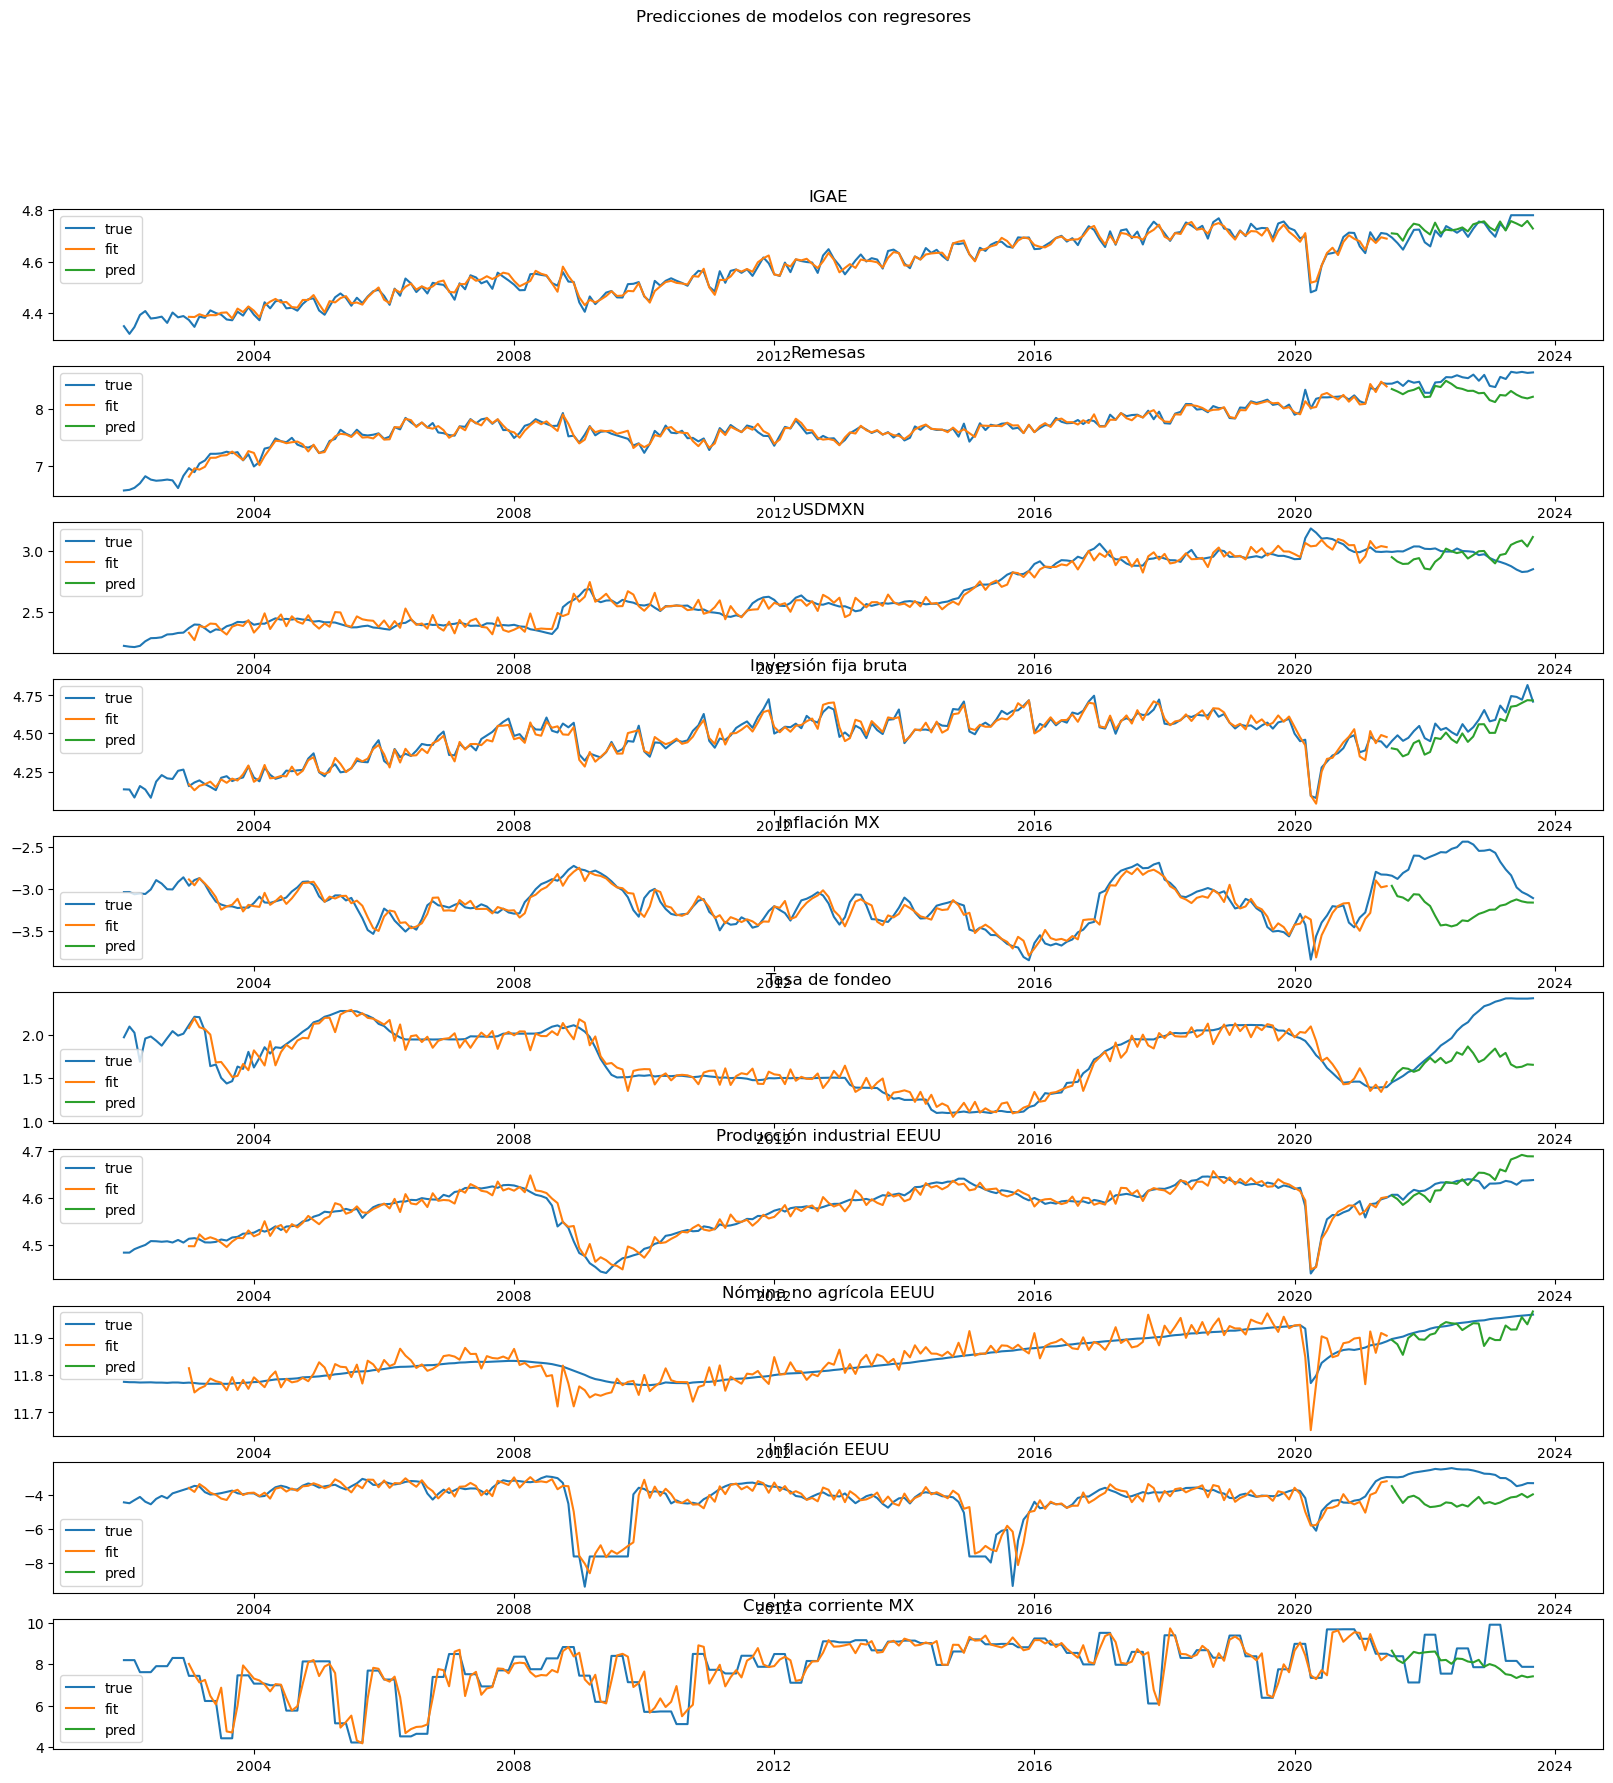

[['IGAE', ('IGAE',)],
 ['Remesas', ('Remesas',)],
 ['USDMXN', ('USDMXN',)],
 ['Inversión fija bruta', ('Inversión fija bruta',)],
 ['Inflación MX', ('Inflación MX',)],
 ['Tasa de fondeo', ('Tasa de fondeo',)],
 ['Producción industrial EEUU', ('Producción industrial EEUU',)],
 ['Nómina no agrícola EEUU', ('Nómina no agrícola EEUU',)],
 ['Inflación EEUU', ('Inflación EEUU',)],
 ['Cuenta corriente MX', ('Cuenta corriente MX',)]]

<Figure size 640x480 with 0 Axes>

In [31]:
fig, axs = plt.subplots(T00,1, figsize=(20, 20), sharey=False)
xk=predicciones_conexp.index
x1=explicativas1.index
check0=[]
for j in range(T00):
    fits=auto_arimas_conexp[j].predict_in_sample(explicativas1.drop(explicativas1.columns[j],axis=1)).iloc[12:]
    axs[j].plot(x1,explicativas1.iloc[:,j],train_set.index[12:],fits,xk,predicciones_conexp.iloc[:,j])
    axs[j].legend(['true','fit','pred'])
    axs[j].set_title(explicativas1.columns[j])
    check0.append([explicativas1.columns[j],predicciones_conexp.columns[j]])
fig.suptitle('Predicciones de modelos con regresores')
plt.show()

plt.savefig('modelos_ARIMA.pdf', format="pdf", bbox_inches="tight")
check0

In [32]:
#predicciones_sinexp.to_csv('/Users/1thaliaespana1/Documents/Semestre II/ambientes/sandbox_Python/estancia_investigacion/modelacion_economica/versiones_balanza_pagos/predicciones_autoarima_230926.csv', index=True, header=True)

In [33]:

#estimadores=pd.DataFrame(auto_arimas).apply(lambda x:x.params())
#estimadores
results=pd.DataFrame({})
for num_var in range(1,3):
    #results.append({'params':[auto_arimas[i].params()],'pvalues':[auto_arimas[i].pvalues()]},ignore_index=True)
    A=pd.concat({explicativas1.columns.values[num_var]:pd.concat([round(auto_arimas_conexp[num_var].params(),2),round(auto_arimas_conexp[num_var].pvalues(),3)],keys=['params','pvalues'],axis=1)})
    results=pd.concat([results,A])

results


params  pvalues
Remesas intercept                     0.02    0.884
        IGAE                          1.30    0.000
        USDMXN                        0.78    0.000
        Inversión fija bruta         -0.17    0.240
        Inflación MX                  0.01    0.634
        Tasa de fondeo               -0.05    0.307
        Producción industrial EEUU    1.39    0.000
        Nómina no agrícola EEUU      -0.58    0.462
        Inflación EEUU                0.01    0.041
        Cuenta corriente MX          -0.01    0.008
        ar.L1                         0.93    0.000
        ma.L1                        -0.23    0.001
        ar.S.L12                      0.58    0.000
        ar.S.L24                      0.18    0.006
        sigma2                        0.00    0.000
USDMXN  IGAE                          2.76    0.000
        Remesas                       0.13    0.001
        Inversión fija bruta         -0.67    0.000
        Inflación MX                 -0.05    0.043
        Tasa de fondeo                0.08    0.017
        Producción industrial EEUU   -1.99    0.000
        Nómina no agrícola EEUU       0.07    0.432
        Inflación EEUU               -0.02    0.004
        Cuenta corriente MX          -0.01    0.120
        ar.L1                         0.40    0.000
        ar.L2                         0.16    0.042
        ar.S.L12                      0.41    0.000
        ar.S.L24                      0.23    0.004
        sigma2                        0.00    0.000

### Resultados RMSE

### 3. Explicación de modelos autoarima, redes neuronales, crossval, inferencia bayesiana

In [34]:
#from nowcast_lstm.LSTM import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(explicativas1, train_size=0.85, test_size=0.15, shuffle=False)

#model=LSTM(df_train, target_variable="Cuenta corriente (I - II)", n_timesteps=10,fill_ragged_edges_func="ARMA")
#model.train()

#### 4.2. Modelo de redes neuronales

In [35]:
def build_dataset(X,Y, hist_size):
  '''
  Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    hist_size: integer indicating the number of time steps in each sample of x
  Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
  '''
  n_samples = Y.shape[0] - hist_size
  x = np.zeros((n_samples, hist_size, X.shape[1]))
  y = np.zeros((n_samples))

  min_max_scaler = MinMaxScaler()
  X = min_max_scaler.fit_transform(X.values)

  for ind in range(n_samples):
    x[ind] = X[ind : ind + hist_size]
    y[ind] = Y[ind + hist_size]
  return x, y
def x_y_split(df):
  ytrain=df.iloc[:,5]
  xtrain=df.drop(df.columns[5],axis=1)
  return xtrain,ytrain

x_train,y_train=x_y_split(df_train)
x_test,y_test=x_y_split(df_test)
x_train,y_train=build_dataset(x_train,y_train,4)
x_test,y_test=build_dataset(x_test,y_test,4)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(217, 4, 9)
(36, 4, 9)
(217,)
(36,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, SimpleRNN, Dense, LeakyReLU
from tensorflow.keras.utils import plot_model

  # Create RNN model
rnn_model = Sequential()
rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
rnn_model.add(SimpleRNN(units=32))
rnn_model.add(Dense(128, activation='sigmoid'))
rnn_model.add(Dense(128, activation='sigmoid'))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dense(1, activation='linear'))

rnn_model.summary()

: 

In [ ]:
rnn_model.compile(loss='mean_squared_error', optimizer='rmsprop')
history = rnn_model.fit(x_train, y_train, epochs=120, batch_size=6, validation_split=0.1)

Epoch 1/120
33/33 [==============================] - 2s 21ms/step - loss: 13.7198 - val_loss: 0.8801
Epoch 2/120
33/33 [==============================] - 0s 4ms/step - loss: 1.7643 - val_loss: 0.9163
Epoch 3/120
33/33 [==============================] - 0s 5ms/step - loss: 1.7497 - val_loss: 2.0240
Epoch 4/120
33/33 [==============================] - 0s 5ms/step - loss: 1.5441 - val_loss: 1.0118
Epoch 5/120
33/33 [==============================] - 0s 5ms/step - loss: 1.2997 - val_loss: 0.7321
Epoch 6/120
33/33 [==============================] - 0s 7ms/step - loss: 1.1884 - val_loss: 0.6896
Epoch 7/120
33/33 [==============================] - 0s 6ms/step - loss: 1.1605 - val_loss: 1.0435
Epoch 8/120
33/33 [==============================] - 0s 4ms/step - loss: 1.1127 - val_loss: 0.9422
Epoch 9/120
33/33 [==============================] - 0s 5ms/step - loss: 1.1352 - val_loss: 0.6892
Epoch 10/120
33/33 [==============================] - 0s 5ms/step - loss: 1.1156 - val_loss: 0.7343
Epoch 1

2/2 [==============================] - 0s 6ms/step
(216, 1) (35, 1)


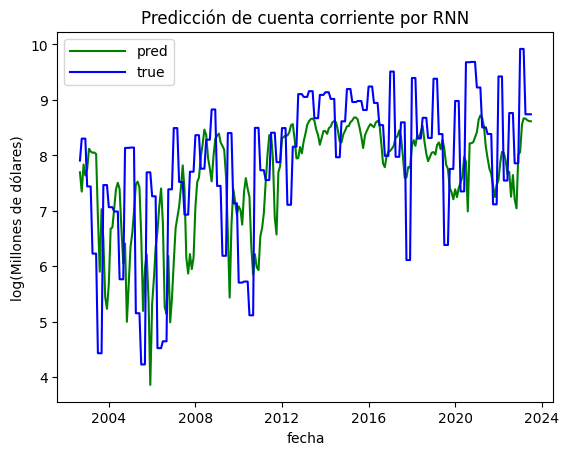

In [ ]:
y_train_hat = rnn_model.predict(x_train)
y_test_hat = rnn_model.predict(x_test)
y_train_hat=pd.DataFrame(y_train_hat).set_index(pd.to_datetime(list(explicativas1.index[:len(y_train_hat)]),format="%Y/%m/%d"))
y_test_hat=pd.DataFrame(y_test_hat).set_index(pd.to_datetime(list(explicativas1.index[-35:]),format="%Y/%m/%d"))
print(y_train_hat.shape,y_test_hat.shape)

xnn=pd.to_datetime(list(explicativas1.index[8:]),format="%Y/%m/%d")
ytrue=explicativas1.iloc[8:,5]
ypred=pd.concat([y_train_hat,y_test_hat])
fig, ax0 = plt.subplots()

ax0.plot(xnn, ypred, 'g-')
ax0.plot(xnn, ytrue, 'b-')
ax0.set_xlabel('fecha')
ax0.set_ylabel('log(Millones de dólares)')
plt.title('Predicción de cuenta corriente por RNN')
plt.legend(['pred','true'],loc='upper left',handlelength=4)

plt.savefig("modelo_RNN.pdf", format="pdf", bbox_inches="tight")

### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM
lstm_model = Sequential()
lstm_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
lstm_model.add(LSTM(units=32))
lstm_model.add(Dense(64, activation='sigmoid'))
lstm_model.add(Dense(128, activation='sigmoid'))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(LeakyReLU())
lstm_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1216      
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 30273 (118.25 KB)
Trainable params: 30273 (118.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop')
history1 = lstm_model.fit(x_train, y_train, epochs=120, batch_size=2, validation_split=0.1)

Epoch 1/120
97/97 [==============================] - 2s 8ms/step - loss: 4.5567 - val_loss: 1.1025
Epoch 2/120
97/97 [==============================] - 0s 2ms/step - loss: 1.7958 - val_loss: 1.0088
Epoch 3/120
97/97 [==============================] - 0s 2ms/step - loss: 1.6802 - val_loss: 0.9541
Epoch 4/120
97/97 [==============================] - 0s 2ms/step - loss: 1.5425 - val_loss: 1.0094
Epoch 5/120
97/97 [==============================] - 0s 2ms/step - loss: 1.4845 - val_loss: 1.0294
Epoch 6/120
97/97 [==============================] - 0s 3ms/step - loss: 1.4481 - val_loss: 0.8526
Epoch 7/120
97/97 [==============================] - 0s 3ms/step - loss: 1.4322 - val_loss: 0.9772
Epoch 8/120
97/97 [==============================] - 0s 3ms/step - loss: 1.3357 - val_loss: 0.8151
Epoch 9/120
97/97 [==============================] - 0s 2ms/step - loss: 1.3566 - val_loss: 1.9257
Epoch 10/120
97/97 [==============================] - 0s 2ms/step - loss: 1.3235 - val_loss: 1.9344
Epoch 11/

2/2 [==============================] - 0s 4ms/step
(216, 1) (35, 1)


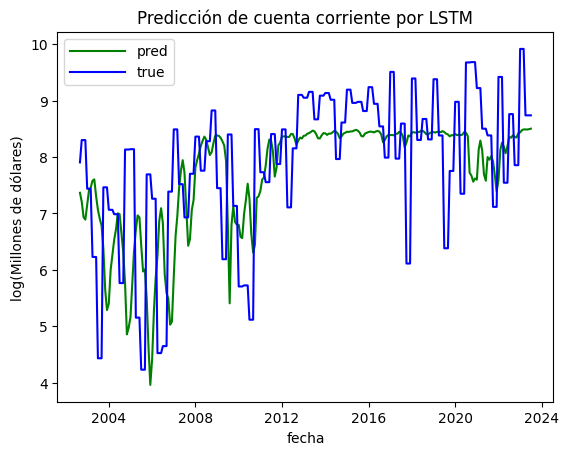

In [ ]:
y_train_hat_lstm = lstm_model.predict(x_train)
y_test_hat_lstm = lstm_model.predict(x_test)
y_train_hat_lstm=pd.DataFrame(y_train_hat_lstm).set_index(pd.to_datetime(list(explicativas1.index[:len(y_train_hat)]),format="%Y/%m/%d"))
y_test_hat_lstm=pd.DataFrame(y_test_hat_lstm).set_index(pd.to_datetime(list(explicativas1.index[-35:]),format="%Y/%m/%d"))
print(y_train_hat_lstm.shape,y_test_hat_lstm.shape)

xnn=pd.to_datetime(list(explicativas1.index[8:]),format="%Y/%m/%d")
ypred_lstm=pd.concat([y_train_hat_lstm,y_test_hat_lstm])

fig, ax0 = plt.subplots()

ax0.plot(xnn, ypred_lstm, 'g-')
ax0.plot(xnn, ytrue, 'b-')
ax0.set_xlabel('fecha')
ax0.set_ylabel('log(Millones de dólares)')
plt.title('Predicción de cuenta corriente por LSTM')
plt.legend(['pred','true'],loc='upper left',handlelength=4)

plt.savefig("modelo_LSTM.pdf", format="pdf", bbox_inches="tight")

### Comparación entre los dos modelos de aprendizaje profundo (LSTM y RNN)

In [ ]:
from sklearn.metrics import mean_squared_error
RMSE_RNN=round(np.sqrt(mean_squared_error(ytrue,ypred)),3)
RMSE_LSTM=round(np.sqrt(mean_squared_error(ytrue,ypred_lstm)),3)
print('RMSE RNN: ',RMSE_RNN)
print('RMSE LSTM: ',RMSE_LSTM)


RMSE RNN:  1.209
RMSE LSTM:  1.215


### 5. Conclusiones

cuadros con pronósticos mes a mes, RMSE de muestra y pronósticos de un año fuera de muestra para todos

gráficas monas

enseñarle a un chavo 3 zooms, básico de cómo ejecutarlo, dónde se genera la red neuronal, dónde se genera el auto arima
en una forma didáctica de hacerlo (colab google y anaconda)


In [ ]:
X_predict,yyy=build_dataset(predicciones_conexp.iloc[:,0:5],predicciones_conexp.iloc[:,5],4)
rnn_predic=pd.DataFrame(rnn_model.predict(X_predict)).set_index([predicciones_conexp.index[4:]]).set_axis(['RNN cuenta corriente'], axis='columns')
lstm_predic=pd.DataFrame(lstm_model.predict(X_predict)).set_index([predicciones_conexp.index[4:]]).set_axis(['LSTM cuenta corriente'], axis='columns')

2/2 [==============================] - 0s 5ms/step


In [ ]:

predicciones=pd.concat([predicciones_conexp,rnn_predic,lstm_predic],axis=1).apply(lambda x:np.exp(x))
predicciones.tail()

(Indicador global de la actividad económica. Total (IGAE) Base 2013 Serie original,)  \
2024-09-30                                         113.117973                                      
2024-10-31                                         117.220598                                      
2024-11-30                                         118.345325                                      
2024-12-31                                         117.191375                                      
2025-01-31                                         114.939456                                      

            (Remesas Familiares Total,)  \
2024-09-30                  7290.053973   
2024-10-31                  7440.055410   
2024-11-30                  7257.617708   
2024-12-31                  7556.658503   
2025-01-31                  7105.767230   

            (Tipo de cambio                                            Pesos por dólar E.U.A. Para solventar obligaciones denominadas en moneda extranjera Fecha de determinación (FIX)                              Cotizaciones promedio,)  \
2024-09-30                                          20.040742                                                                                                                                                                                  
2024-10-31                                          20.040742                                                                                                                                                                                  
2024-11-30                                          20.040742                                                                                                                                                                                  
2024-12-31                                          20.040742                                                                                                                                                                                  
2025-01-31                                          20.040742                                                                                                                                                                                  

            (Indice de volumen de la inversión fija bruta Total,)  \
2024-09-30                                          92.410312       
2024-10-31                                          94.209577       
2024-11-30                                          95.778093       
2024-12-31                                          97.089311       
2025-01-31                                          90.878459       

            (IPC Por objeto del gasto                                                         Nacional I n d i c e   G e n e r a l,)  \
2024-09-30                                         129.655722                                                                          
2024-10-31                                         130.283441                                                                          
2024-11-30                                         130.948905                                                                          
2024-12-31                                         131.533970                                                                          
2025-01-31                                         132.210736                                                                          

            ( Cuenta corriente (I - II),)  RNN cuenta corriente  \
2024-09-30                    9255.621424            329.586945   
2024-10-31                    9590.184287           1078.216187   
2024-11-30                    9590.184287           1994.809448   
2024-12-31                    9590.184287           3354.206543   
2025-01-31                   11331.454014           4025.957520   

            LSTM cuenta corriente  
2024-09-30            1443.506958  
2024

In [ ]:
RMSES=list(RMSE01['RMSE'])
predicciones.loc[len(predicciones.index)] = RMSES+[RMSE_RNN]+[RMSE_LSTM]

In [ ]:
exportar_cuadro=pd.concat([predicciones.iloc[-1:], predicciones.iloc[:-1]], axis=0).rename(index={44:'RMSE'})
exportar_cuadro

(Indicador global de la actividad económica. Total (IGAE) Base 2013 Serie original,)  \
RMSE                                                          0.029000                                      
2021-06-30 00:00:00                                         111.365940                                      
2021-07-31 00:00:00                                         111.299043                                      
2021-08-31 00:00:00                                         111.717155                                      
2021-09-30 00:00:00                                         109.713842                                      
2021-10-31 00:00:00                                         114.702144                                      
2021-11-30 00:00:00                                         116.077324                                      
2021-12-31 00:00:00                                         114.666457                                      
2022-01-31 00:00:00                                         111.923104                                      
2022-02-28 00:00:00                                         109.530662                                      
2022-03-31 00:00:00                                         113.557884                                      
2022-04-30 00:00:00                                         107.758471                                      
2022-05-31 00:00:00                                         110.336640                                      
2022-06-30 00:00:00                                         111.887142                                      
2022-07-31 00:00:00                                         112.409158                                      
2022-08-31 00:00:00                                         112.801322                                      
2022-09-30 00:00:00                                         110.921376                                      
2022-10-31 00:00:00                                         115.598057                                      
2022-11-30 00:00:00                                         116.884757                                      
2022-12-31 00:00:00                                         115.564651                                      
2023-01-31 00:00:00                                         112.994452                                      
2023-02-28 00:00:00                                         110.749355                                      
2023-03-31 00:00:00                                         114.526582                                      
2023-04-30 00:00:00                                         109.084060                                      
2023-05-31 00:00:00                                         111.506081                                      
2023-06-30 00:00:00                                         112.960731                                      
2023-07-31 00:00:00                                         113.450152                                      
2023-08-31 00:00:00                                         113.817722                                      
2023-09-30 00:00:00                                         112.054838                                      
2023-10-31 00:00:00                                         116.436450                                      
2023-11-30 00:00:00                                         117.639734                                      
2023-12-31 00:00:00                                         116.405198                                      
2024-01-31 00:00:00                                         113.998707                                      
2024-02-29 00:00:00                                         111.893423                                      
2024-03-31 00:00:00                                         115.433712                                      
2024-04-30 00:00:00                                         110.329873                           

In [ ]:
exportar_cuadro.to_csv('cuadro_predicciones_cuenta_corriente031023.csv')